In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.cluster import MiniBatchKMeans # For robust GMM initialization

In [7]:
# =============================================================================
# --- Simulation Definitions (Bird, Model, Utility & Thermodynamic Functions) ---
# =============================================================================

class Bird:
    """
    Represents a single bird agent in the flocking simulation.
    Each bird has a position, velocity, speed, and parameters governing its
    interaction with neighbors (cohesion, separation, alignment).
    It also maintains a history of its local ensemble size for thermodynamic calculations.
    """
    def __init__(self, pos, vel, speed, cohere_factor, separation,
                 separate_factor, match_factor, visual_distance, ensemble, history_length):
        self.pos = np.array(pos, dtype=np.float64)
        self.vel = np.array(vel, dtype=np.float64)
        # Ensure the initial velocity is a unit vector
        norm_vel = np.linalg.norm(self.vel)
        self.vel = self.vel / norm_vel if norm_vel > 0 else np.array([1.0, 0.0]) # Default if vel is zero
        self.speed = speed
        self.cohere_factor = cohere_factor
        self.separation = separation
        self.separate_factor = separate_factor
        self.match_factor = match_factor
        self.visual_distance = visual_distance
        self.ensemble = ensemble # Represents a local 'energy' or 'state' of the bird
        self.ensemble_history = deque(maxlen=history_length) # History for ensemble calculation

class Model:
    """
    Represents the overall flocking simulation environment.
    Manages all bird agents, their interactions, and the simulation's state over time.
    """
    def __init__(self, n_birds=100, speed=2.0, cohere_factor=0.4, separation=4.0,
                 separate_factor=0.25, match_factor=0.02, visual_distance=5.0,
                 ensemble=1, history_length=8, extent=(50, 50), seed=1234):
        self.iteration = 0 # Current simulation step
        self.extent = extent  # (width, height) of the simulation area
        self.agents = []      # List of all bird agents
        self.rng = np.random.default_rng(seed) # Random number generator for reproducibility
        
        # Initialize each bird agent with random positions and velocities
        for _ in range(n_birds):
            vel = self.rng.uniform(-1, 1, size=2)
            if np.linalg.norm(vel) == 0:
                vel = np.array([1.0, 0.0]) # Default velocity if randomly generated is zero
            else:
                vel = vel / np.linalg.norm(vel) # Normalize to unit vector
            pos = self.rng.uniform(low=[0, 0], high=extent, size=2) # Random position within extent
            
            bird = Bird(pos, vel, speed, cohere_factor, separation,
                        separate_factor, match_factor, visual_distance,
                        ensemble, history_length)
            self.agents.append(bird)

def move_agent(agent, model):
    """Moves the agent based on its velocity and speed, applying periodic boundary conditions."""
    agent.pos += agent.vel * agent.speed
    # Apply periodic boundary conditions (toroidal world)
    agent.pos[0] %= model.extent[0]
    agent.pos[1] %= model.extent[1]

def get_neighbors(agent, model, radius):
    """
    Returns a list of agents within the specified radius of the given agent,
    excluding the agent itself.
    """
    neighbors = []
    for other in model.agents:
        if other is agent:
            continue # Skip self
        if np.linalg.norm(agent.pos - other.pos) < radius:
            neighbors.append(other)
    return neighbors

def agent_step(agent, model):
    """
    Updates an individual agent's velocity based on Boids rules (cohesion, separation, alignment)
    and then moves the agent.
    """
    neighbors = get_neighbors(agent, model, agent.visual_distance)
    
    # Initialize rule vectors
    match = np.array([0.0, 0.0])    # Alignment
    separate = np.array([0.0, 0.0]) # Separation
    cohere = np.array([0.0, 0.0])   # Cohesion
    
    bird_speed = np.linalg.norm(agent.vel)
    
    # Apply Boids rules based on neighbors
    for neighbor in neighbors:
        heading = neighbor.pos - agent.pos
        cohere += heading # Sum of vectors towards neighbors for cohesion
        
        if np.linalg.norm(heading) < agent.separation:
            separate -= heading # Move away from close neighbors for separation
        
        match += neighbor.vel # Sum of neighbor velocities for alignment
        
        # The 'angle_between' calculation is present but 'ensemble_count' is unused.
        # Keeping the angle calculation for potential future use or if it was part of a discarded rule.
        neighbor_speed = np.linalg.norm(neighbor.vel)
        if bird_speed * neighbor_speed > 0:
            cos_angle = np.dot(agent.vel, neighbor.vel) / (bird_speed * neighbor_speed + 1e-9)
            cos_angle = np.clip(cos_angle, -1, 1)
            _ = np.arccos(cos_angle) # Calculate angle, but result is not used further in this function
    
    N = max(len(neighbors), 1) # Number of neighbors (at least 1 to avoid division by zero)
    
    # Update ensemble history and calculate current ensemble value
    agent.ensemble_history.append(len(neighbors))
    median_history = np.median(list(agent.ensemble_history)) if len(agent.ensemble_history) > 0 else 0
    agent.ensemble = 1 / (1 + median_history) # Ensemble value (e.g., inverse of local density)
    
    # Weight and normalize rule contributions
    cohere = (cohere / N) * agent.cohere_factor
    separate = (separate / N) * agent.separate_factor
    match = (match / N) * agent.match_factor
    
    # Combine current velocity with rule contributions
    new_vel = (agent.vel + cohere + separate + match) / 2.0 # Simple averaging
    norm_new_vel = np.linalg.norm(new_vel)
    agent.vel = new_vel / norm_new_vel if norm_new_vel > 0 else agent.vel # Normalize new velocity
    
    move_agent(agent, model) # Move the agent

def model_step(model):
    """Advances the simulation model by one iteration."""
    model.iteration += 1

def Step_Num(model):
    """Returns the current iteration number of the model."""
    return model.iteration

# -------------------------------
# Thermodynamic Quantities
# -------------------------------

def Model_Ensemble_Energy(model):
    """Calculates the total ensemble energy of the model (sum of individual bird ensembles)."""
    return sum(bird.ensemble for bird in model.agents)

def Model_Energy_DistributionFN(model, bins=10):
    """
    Calculates the probability distribution function (PDF) of ensemble energies
    across all birds in the model.
    """
    energies = np.array([bird.ensemble for bird in model.agents], dtype=float)
    counts, bin_edges = np.histogram(energies, bins=bins, density=False) # Get raw counts
    total_count = np.sum(counts)
    pdf = counts / total_count if total_count > 0 else np.zeros_like(counts, dtype=float) # Normalize to get PDF
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    energy_distribution = list(zip(bin_midpoints, pdf))
    return energy_distribution

def Model_Entropy(e_p_array):
    """
    Calculates the Shannon entropy of the given energy probability distribution.
    S = -sum(p * log(p))
    """
    S = 0.0
    for _, p in e_p_array:
        if p > 0: # Avoid log(0)
            S -= p * np.log(p)
    return S

def Model_Temperature(e_p_array):
    """
    Estimates the 'temperature' of the system based on the energy distribution.
    This is a simplified approximation, often related to the inverse of the slope
    of log(p) vs E.
    """
    sum_result = 0.0
    for i in range(1, len(e_p_array)):
        E_prev, p_prev = e_p_array[i - 1]
        E, p = e_p_array[i]
        delta_E = E - E_prev
        
        # Avoid division by zero or very small delta_E
        if abs(delta_E) < 1e-9: # If energy difference is negligible
            continue
        
        dp_dE = (p - p_prev) / delta_E
        
        # Avoid issues with extreme or zero slopes in dp_dE
        if abs(dp_dE) < 1e-9 or abs(dp_dE) > 1e8:
            continue
        
        if p > 0:
            sum_result += dp_dE * np.log(p)
            
    if sum_result == 0:
        return 0.0 # Return 0 if no meaningful sum can be computed
    else:
        T = -1 / sum_result
        return abs(T) # Temperature should be positive

def Model_Heat(S_current, S_prev, T_current):
    """Calculates the 'heat' transfer (dQ) based on change in entropy and temperature."""
    dS = S_current - S_prev
    dQ = abs(T_current) * dS
    return dQ

# Global variable to store the previous entropy for dQ calculation across steps
S_prev_global = None 
def Model_Thermo_State(model):
    """
    Calculates and returns a dictionary of key thermodynamic state variables:
    Entropy (S), Temperature (T), Heat (dQ), and the energy probability array.
    Manages the global S_prev_global for dQ calculation.
    """
    global S_prev_global
    e_p_array = Model_Energy_DistributionFN(model)
    S = Model_Entropy(e_p_array)
    T = Model_Temperature(e_p_array)
    dQ = 0.0
    if S_prev_global is not None:
        dQ = Model_Heat(S, S_prev_global, T)
    S_prev_global = S # Update global for next iteration
    return {"S": S, "T": T, "dQ": dQ, "e_p_array": e_p_array}

def Model_Internal_Energy(model):
    """Calculates the internal energy of the model based on the energy distribution."""
    e_p_array = Model_Energy_DistributionFN(model)
    tmp_U = sum(E * p for E, p in e_p_array)
    return tmp_U

def Model_Volume(model):
    """
    Estimates the 'volume' of the flock based on the average pairwise distance
    between birds. A larger average distance implies a larger volume.
    """
    birds = model.agents
    total_distance = 0.0
    count = 0
    n = len(birds)
    # Calculate sum of distances for all unique pairs
    for i in range(n - 1):
        for j in range(i + 1, n):
            total_distance += np.linalg.norm(birds[i].pos - birds[j].pos)
            count += 1
    
    average_distance = total_distance / count if count > 0 else 0.0
    # Volume is inversely proportional to average distance (a simple proxy)
    return 1 / average_distance if average_distance > 0 else 0.0

def Flock_Model_State(model):
    """Returns a simple state metric for the flock, currently the ensemble energy."""
    return Model_Ensemble_Energy(model)

In [8]:
def run_simulation(model, step_num, agent_data_funcs, model_data_funcs):
    """
    Runs the flocking simulation for a given number of steps.
    Records specified agent-level attributes and model-level function outputs at each step.
    
    Args:
        model: The Model instance to simulate.
        step_num: The number of simulation steps to run.
        agent_data_funcs: List of attribute names (strings) to record for each agent.
        model_data_funcs: List of functions (callable) to record model-level data.
    
    Returns:
        tuple: (agent_records, model_records)
            agent_records: List of lists, where each inner list contains dictionaries
                           of agent attributes for a given step.
            model_records: List of dictionaries, where each dictionary contains
                           model-level function results for a given step.
    """
    agent_records = []
    model_records = []
    for _ in range(step_num):
        # Update each agent's state
        for agent in model.agents:
            agent_step(agent, model)
        model_step(model) # Advance model iteration
        
        # Record agent data for the current step
        agents_snapshot = []
        for agent in model.agents:
            record = {attr: getattr(agent, attr) for attr in agent_data_funcs}
            agents_snapshot.append(record)
        agent_records.append(agents_snapshot)
        
        # Record model-level data for the current step
        model_record = {}
        for func in model_data_funcs:
            model_record[func.__name__] = func(model)
        model_records.append(model_record)
    return agent_records, model_records

In [53]:
%matplotlib inline
# =============================================================================
# --- GMM Training and Analysis Functions ---
# =============================================================================

def extract_features_from_model_df(model_df):
    """
    Extracts key thermodynamic features (Energy, Entropy, Temperature, dQ, Volume)
    from a DataFrame of model-level simulation data.
    Adds a small amount of Gaussian noise to stabilize data for GMM training.
    """
    S_vals = model_df["Model_Thermo_State"].apply(lambda x: x.get("S", 0.0)).to_numpy()
    T_vals = model_df["Model_Thermo_State"].apply(lambda x: x.get("T", 0.0)).to_numpy()
    dQ_vals = model_df["Model_Thermo_State"].apply(lambda x: x.get("dQ", 0.0)).to_numpy()
    E_vals = model_df["Model_Ensemble_Energy"].to_numpy()
    V_vals = model_df["Model_Volume"].to_numpy()
    
    data = np.column_stack((E_vals, S_vals, T_vals, dQ_vals, V_vals))
    # Add small noise to prevent singular covariance matrices if data points are identical
    data += 1e-6 * np.random.randn(*data.shape)
    return data

def train_gmm(data, num_clusters):
    """Trains a Gaussian Mixture Model on the given feature data."""
    print(f"Training Gaussian Mixture Model with {num_clusters} clusters...")
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
    gmm.fit(data)
    return gmm

def enforce_thermodynamic_constraints(gmm, data):
    """
    Applies a simplified 'thermodynamic constraint' example.
    In a real physical system, certain thermodynamic laws (e.g., entropy increase
    in isolated systems) might be used to guide or refine clustering.
    This function demonstrates a conceptual check and a simple adjustment.
    """
    entropy_values = data[:, 1]  # Entropy is the second column (index 1)
    
    # Example constraint check: if entropy is not generally increasing (simplified)
    # A more rigorous check would involve statistical tests or physical models.
    if np.any(np.diff(entropy_values) < 0): 
        print("Warning: Entropy is not strictly non-decreasing in some segments. This might indicate non-equilibrium or open system behavior.")
    
    # Example 'adjustment': if average energy is high, suggest a 'cooler' state
    if np.mean(data[:, 0]) > 0.5: 
        print("Adjusting GMM: High average energy observed, potentially indicating a less cohesive state.")
        # Re-train GMM with slightly scaled data to conceptually 'cool down' the system
        num_components = gmm.n_components
        data_adjusted = data * 0.95 # Artificially scale down features
        gmm_adjusted = GaussianMixture(n_components=num_components, covariance_type='full', random_state=42)
        gmm_adjusted.fit(data_adjusted)
        return gmm_adjusted
    return gmm

# --- Plotting Functions for Thermodynamic Evolution ---

def plot_internal_energy(energy_array, title_prefix=""):
    """Plots the evolution of internal energy over simulation steps."""
    plt.figure(figsize=(10, 6))
    plt.plot(energy_array, label="Internal Energy")
    plt.title(f"{title_prefix}Internal Energy Evolution")
    plt.xlabel("Simulation Step")
    plt.ylabel("Internal Energy")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

def plot_cumsum_dQ(dQ_array, title_prefix=""):
    """Plots the cumulative sum of heat transfer (dQ) over simulation steps."""
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(dQ_array), label="Cumulative dQ")
    plt.title(f"{title_prefix}Cumulative Sum of Heat (dQ)")
    plt.xlabel("Simulation Step")
    plt.ylabel("Cumulative dQ")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

def plot_volume(volume_array, title_prefix=""):
    """Plots the evolution of the flock's 'volume' over simulation steps."""
    plt.figure(figsize=(10, 6))
    plt.plot(volume_array, label="Volume")
    plt.title(f"{title_prefix}Volume Evolution")
    plt.xlabel("Simulation Step")
    plt.ylabel("Volume")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# --- Functions to Merge and Normalize Energy Distribution Arrays ---

def merge_e_p_array(ep_tmp, e_p_sums):
    """
    Merges energy probability distributions from a new simulation run
    into an accumulated sum. This is useful for averaging distributions.
    
    Args:
        ep_tmp (list): List of (E, p) tuples for each step of the current run.
        e_p_sums (list): Accumulated list of (E, p) tuples from previous runs.
    
    Returns:
        list: The updated accumulated list of (E, p) tuples.
    """
    new_e_p_array = []
    for i in range(len(ep_tmp)):
        # Convert to dictionary for efficient merging by energy value
        merged_dict = dict(e_p_sums[i]) 
        for E, p in ep_tmp[i]:
            merged_dict[E] = merged_dict.get(E, 0.0) + p
        
        # Convert back to list of tuples and sort by energy for consistent order
        new_e_p_array.append(sorted(list(merged_dict.items())))
    return new_e_p_array

def normalize_e_p_array(e_p_array):
    """
    Normalizes a list of energy probability arrays so that the probabilities
    for each step sum to 1.
    """
    normalized = []
    for arr in e_p_array:
        total_probability = sum(p for (_, p) in arr)
        if total_probability != 0:
            normalized.append([(E, p / total_probability) for (E, p) in arr])
        else:
            normalized.append(arr) # If total_probability is 0, append as is
    return normalized

# --- Bird Marker and Plot Function for Enhanced Visualization ---

# Define a base polygon shape for a bird marker
bird_polygon = np.array([[-1, -1], [2, 0], [-1, 1]]) # Simple triangle

def bird_marker(bird):
    """
    Rotates the base bird polygon based on the bird's velocity direction
    and translates it to the bird's current position.
    """
    phi = np.arctan2(bird.vel[1], bird.vel[0]) # Angle of velocity vector
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi),  np.cos(phi)]]) # Rotation matrix
    rotated = (R @ bird_polygon.T).T # Apply rotation
    rotated += bird.pos  # Apply translation to bird's position
    return rotated

def plot_birds_iter(model, heat_tmp, iteration_tmp):
    """
    Plots all bird agents as rotated polygons, indicating their position and direction.
    Includes current heat and iteration in the title.
    """
    title_str = f"Avg. Heat={heat_tmp:.2f} at Iteration={iteration_tmp}"
    fig, ax = plt.subplots(figsize=(8, 8))
    for bird in model.agents:
        poly_points = bird_marker(bird)
        polygon = Polygon(poly_points, closed=True, edgecolor='k', facecolor='gray', alpha=0.8)
        ax.add_patch(polygon)
    ax.set_xlim(0, model.extent[0])
    ax.set_ylim(0, model.extent[1])
    ax.set_title(title_str, fontsize=16)
    ax.set_aspect('equal') # Ensure aspect ratio is equal for correct visualization
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.show()
    return fig

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture

# =============================================================================
# --- Simulation Definitions (Bird, Model, Utility & Thermodynamic Functions) ---
# =============================================================================

class Bird:
    """
    Represents a single bird agent in the flocking simulation.
    Each bird has a position, velocity, speed, and parameters governing its
    interaction with neighbors (cohesion, separation, alignment).
    It also maintains a history of its local ensemble size for thermodynamic calculations.
    """
    def __init__(self, pos, vel, speed, cohere_factor, separation,
                 separate_factor, match_factor, visual_distance, ensemble, history_length):
        self.pos = np.array(pos, dtype=np.float64)
        self.vel = np.array(vel, dtype=np.float64)
        # Ensure the initial velocity is a unit vector
        norm_vel = np.linalg.norm(self.vel)
        self.vel = self.vel / norm_vel if norm_vel > 0 else np.array([1.0, 0.0]) # Default if vel is zero
        self.speed = speed
        self.cohere_factor = cohere_factor
        self.separation = separation
        self.separate_factor = separate_factor
        self.match_factor = match_factor
        self.visual_distance = visual_distance
        self.ensemble = ensemble # Represents a local 'energy' or 'state' of the bird
        self.ensemble_history = deque(maxlen=history_length) # History for ensemble calculation

class Model:
    """
    Represents the overall flocking simulation environment.
    Manages all bird agents, their interactions, and the simulation's state over time.
    """
    def __init__(self, n_birds=100, speed=2.0, cohere_factor=0.4, separation=4.0,
                 separate_factor=0.25, match_factor=0.02, visual_distance=5.0,
                 ensemble=1, history_length=8, extent=(50, 50), seed=1234):
        self.iteration = 0 # Current simulation step
        self.extent = extent   # (width, height) of the simulation area
        self.agents = []       # List of all bird agents
        self.rng = np.random.default_rng(seed) # Random number generator for reproducibility

        # Initialize each bird agent with random positions and velocities
        for _ in range(n_birds):
            vel = self.rng.uniform(-1, 1, size=2)
            if np.linalg.norm(vel) == 0:
                vel = np.array([1.0, 0.0]) # Default velocity if randomly generated is zero
            else:
                vel = vel / np.linalg.norm(vel) # Normalize to unit vector
            pos = self.rng.uniform(low=[0, 0], high=extent, size=2) # Random position within extent

            bird = Bird(pos, vel, speed, cohere_factor, separation,
                        separate_factor, match_factor, visual_distance,
                        ensemble, history_length)
            self.agents.append(bird)

def move_agent(agent, model):
    """Moves the agent based on its velocity and speed, applying periodic boundary conditions."""
    agent.pos += agent.vel * agent.speed
    # Apply periodic boundary conditions (toroidal world)
    agent.pos[0] %= model.extent[0]
    agent.pos[1] %= model.extent[1]

def get_neighbors(agent, model, radius):
    """
    Returns a list of agents within the specified radius of the given agent,
    excluding the agent itself.
    """
    neighbors = []
    for other in model.agents:
        if other is agent:
            continue # Skip self
        if np.linalg.norm(agent.pos - other.pos) < radius:
            neighbors.append(other)
    return neighbors

def agent_step(agent, model):
    """
    Updates an individual agent's velocity based on Boids rules (cohesion, separation, alignment)
    and then moves the agent.
    """
    neighbors = get_neighbors(agent, model, agent.visual_distance)

    # Initialize rule vectors
    match = np.array([0.0, 0.0])    # Alignment
    separate = np.array([0.0, 0.0]) # Separation
    cohere = np.array([0.0, 0.0])   # Cohesion

    bird_speed = np.linalg.norm(agent.vel)

    # Apply Boids rules based on neighbors
    for neighbor in neighbors:
        heading = neighbor.pos - agent.pos
        cohere += heading # Sum of vectors towards neighbors for cohesion

        if np.linalg.norm(heading) < agent.separation:
            separate -= heading # Move away from close neighbors for separation

        match += neighbor.vel # Sum of neighbor velocities for alignment

        # The 'angle_between' calculation is present but 'ensemble_count' is unused.
        # Keeping the angle calculation for potential future use or if it was part of a discarded rule.
        neighbor_speed = np.linalg.norm(neighbor.vel)
        if bird_speed * neighbor_speed > 0:
            cos_angle = np.dot(agent.vel, neighbor.vel) / (bird_speed * neighbor_speed + 1e-9)
            cos_angle = np.clip(cos_angle, -1, 1)
            _ = np.arccos(cos_angle) # Calculate angle, but result is not used further in this function

    N = max(len(neighbors), 1) # Number of neighbors (at least 1 to avoid division by zero)

    # Update ensemble history and calculate current ensemble value
    agent.ensemble_history.append(len(neighbors))
    median_history = np.median(list(agent.ensemble_history)) if len(agent.ensemble_history) > 0 else 0
    agent.ensemble = 1 / (1 + median_history) # Ensemble value (e.g., inverse of local density)

    # Weight and normalize rule contributions
    cohere = (cohere / N) * agent.cohere_factor
    separate = (separate / N) * agent.separate_factor
    match = (match / N) * agent.match_factor

    # Combine current velocity with rule contributions
    new_vel = (agent.vel + cohere + separate + match) / 2.0 # Simple averaging
    norm_new_vel = np.linalg.norm(new_vel)
    agent.vel = new_vel / norm_new_vel if norm_new_vel > 0 else agent.vel # Normalize new velocity

    move_agent(agent, model) # Move the agent

def model_step(model):
    """Advances the simulation model by one iteration."""
    model.iteration += 1

def Step_Num(model):
    """Returns the current iteration number of the model."""
    return model.iteration




In [55]:
# -------------------------------
# Thermodynamic Quantities
# -------------------------------

def Model_Ensemble_Energy(model):
    """Calculates the total ensemble energy of the model (sum of individual bird ensembles)."""
    return sum(bird.ensemble for bird in model.agents)

def Model_Energy_DistributionFN(model, bins=10):
    """
    Calculates the probability distribution function (PDF) of ensemble energies
    across all birds in the model.
    """
    energies = np.array([bird.ensemble for bird in model.agents], dtype=float)
    counts, bin_edges = np.histogram(energies, bins=bins, density=False) # Get raw counts
    total_count = np.sum(counts)
    pdf = counts / total_count if total_count > 0 else np.zeros_like(counts, dtype=float) # Normalize to get PDF
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    energy_distribution = list(zip(bin_midpoints, pdf))
    return energy_distribution

def Model_Entropy(e_p_array):
    """
    Calculates the Shannon entropy of the given energy probability distribution.
    S = -sum(p * log(p))
    """
    S = 0.0
    for _, p in e_p_array:
        if p > 0: # Avoid log(0)
            S -= p * np.log(p)
    return S

def Model_Temperature(e_p_array):
    """
    Estimates the 'temperature' of the system based on the energy distribution.
    This is a simplified approximation, often related to the inverse of the slope
    of log(p) vs E.
    """
    sum_result = 0.0
    for i in range(1, len(e_p_array)):
        E_prev, p_prev = e_p_array[i - 1]
        E, p = e_p_array[i]
        delta_E = E - E_prev

        # Avoid division by zero or very small delta_E
        if abs(delta_E) < 1e-9: # If energy difference is negligible
            continue

        dp_dE = (p - p_prev) / delta_E

        # Avoid issues with extreme or zero slopes in dp_dE
        if abs(dp_dE) < 1e-9 or abs(dp_dE) > 1e8:
            continue

        if p > 0:
            sum_result += dp_dE * np.log(p)

    if sum_result == 0:
        return 0.0 # Return 0 if no meaningful sum can be computed
    else:
        T = -1 / sum_result
        return abs(T) # Temperature should be positive

def Model_Heat(S_current, S_prev, T_current):
    """Calculates the 'heat' transfer (dQ) based on change in entropy and temperature."""
    dS = S_current - S_prev
    dQ = abs(T_current) * dS
    return dQ

# Global variable to store the previous entropy for dQ calculation across steps
S_prev_global = None
def Model_Thermo_State(model):
    """
    Calculates and returns a dictionary of key thermodynamic state variables:
    Entropy (S), Temperature (T), Heat (dQ), and the energy probability array.
    Manages the global S_prev_global for dQ calculation.
    """
    global S_prev_global
    e_p_array = Model_Energy_DistributionFN(model)
    S = Model_Entropy(e_p_array)
    T = Model_Temperature(e_p_array)
    dQ = 0.0
    if S_prev_global is not None:
        dQ = Model_Heat(S, S_prev_global, T)
    S_prev_global = S # Update global for next iteration
    return {"S": S, "T": T, "dQ": dQ, "e_p_array": e_p_array}

def Model_Internal_Energy(model):
    """Calculates the internal energy of the model based on the energy distribution."""
    e_p_array = Model_Energy_DistributionFN(model)
    tmp_U = sum(E * p for E, p in e_p_array)
    return tmp_U

def Model_Volume(model):
    """
    Estimates the 'volume' of the flock based on the average pairwise distance
    between birds. A larger average distance implies a larger volume.
    """
    birds = model.agents
    total_distance = 0.0
    count = 0
    n = len(birds)
    # Calculate sum of distances for all unique pairs
    for i in range(n - 1):
        for j in range(i + 1, n):
            total_distance += np.linalg.norm(birds[i].pos - birds[j].pos)
            count += 1

    average_distance = total_distance / count if count > 0 else 0.0
    # Volume is inversely proportional to average distance (a simple proxy)
    return 1 / average_distance if average_distance > 0 else 0.0

def Flock_Model_State(model):
    """Returns a simple state metric for the flock, currently the ensemble energy."""
    return Model_Ensemble_Energy(model)


def run_simulation(model, step_num, agent_data_funcs, model_data_funcs):
    """
    Runs the flocking simulation for a given number of steps.
    Records specified agent-level attributes and model-level function outputs at each step.

    Args:
        model: The Model instance to simulate.
        step_num: The number of simulation steps to run.
        agent_data_funcs: List of attribute names (strings) to record for each agent.
        model_data_funcs: List of functions (callable) to record model-level data.

    Returns:
        tuple: (agent_records, model_records)
            agent_records: List of lists, where each inner list contains dictionaries
                            of agent attributes for a given step.
            model_records: List of dictionaries, where each dictionary contains
                            model-level function results for a given step.
    """
    agent_records = []
    model_records = []
    for _ in range(step_num):
        # Update each agent's state
        for agent in model.agents:
            agent_step(agent, model)
        model_step(model) # Advance model iteration

        # Record agent data for the current step
        agents_snapshot = []
        for agent in model.agents:
            record = {attr: getattr(agent, attr) for attr in agent_data_funcs}
            agents_snapshot.append(record)
        agent_records.append(agents_snapshot)

        # Record model-level data for the current step
        model_record = {}
        for func in model_data_funcs:
            model_record[func.__name__] = func(model)
        model_records.append(model_record)
    return agent_records, model_records




--- Plotting Thermodynamic Evolution ---


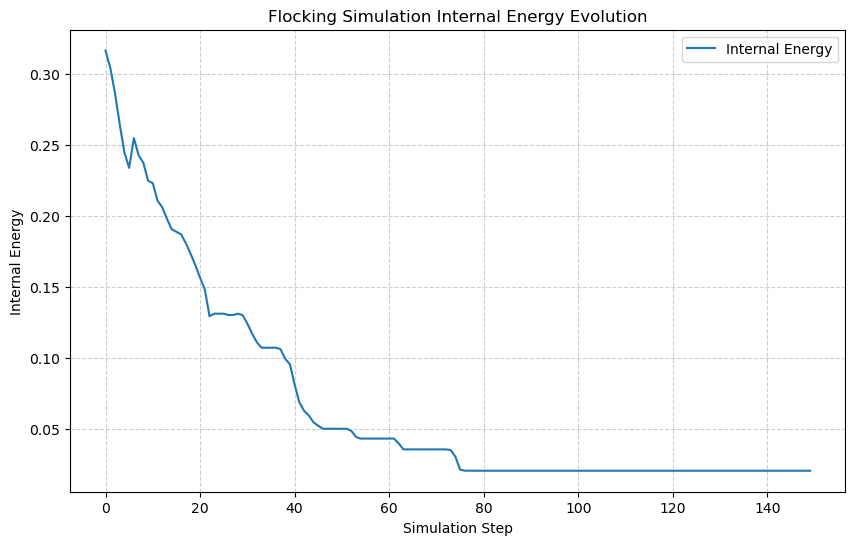

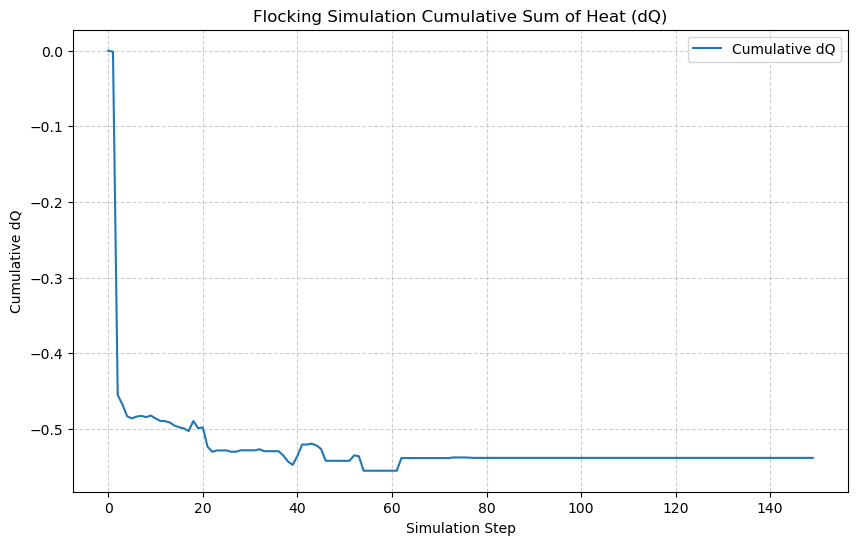

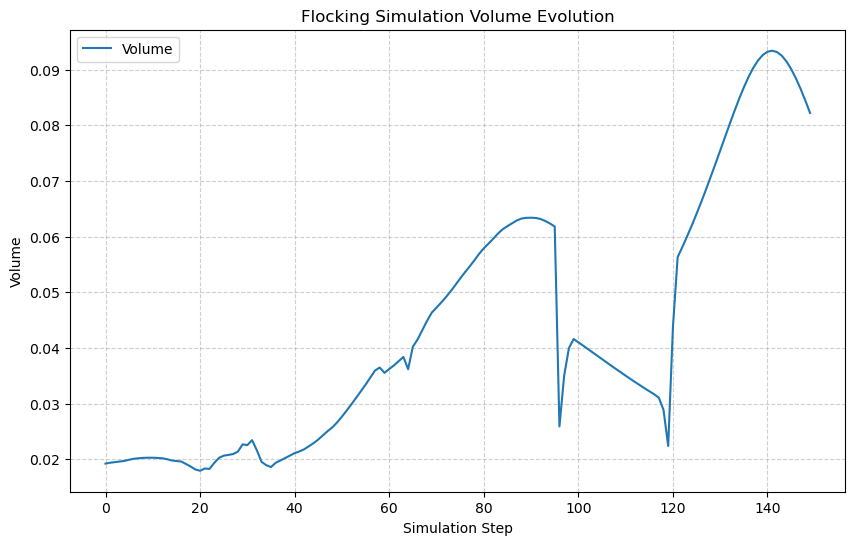


--- Plotting Bird States at Last Iteration ---


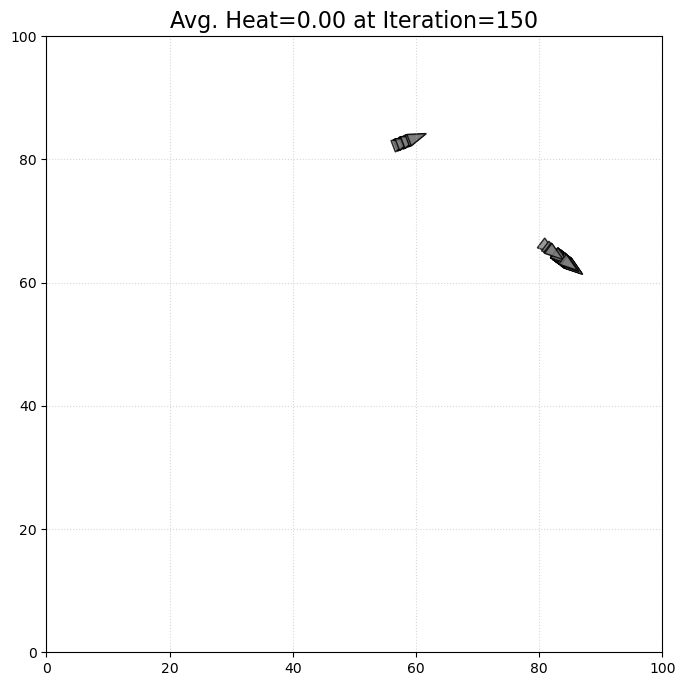


--- Gaussian Mixture Model Analysis ---
Training Gaussian Mixture Model with 3 clusters...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Adjusting GMM: High average energy observed, potentially indicating a less cohesive state.

Original GMM Converged: True
Original GMM Weights: [0.7333296  0.22615893 0.04051147]
Original GMM Means (E, S, T, dQ, V):
[[ 2.71330950e+00  5.63662424e-01  2.27518391e-02  8.47218089e-05
   5.16491095e-02]
 [ 1.49840817e+01  7.74040723e-01  1.32770366e-01 -1.14627197e-03
   2.01239906e-02]
 [ 2.59166495e+01  1.19479815e+00  9.32956975e-01 -8.37030577e-02
   1.93170817e-02]]
Original GMM Covariances:
[[[ 1.51366018e+00  6.30373074e-02  2.06818505e-02  5.79061344e-04
   -1.53572767e-02]
  [ 6.30373074e-02  2.79995184e-02 -2.03221716e-03  1.79810162e-04
   -4.99159712e-04]
  [ 2.06818505e-02 -2.03221716e-03  8.29759697e-04 -1.08039744e-05
   -2.40554994e-04]
  [ 5.79061344e-04  1.79810162e-04 -1.08039744e-05  1.32370555e-05
   -2.04426112e-06]
  [-1.53572767e-02 -4.99159712e-04 -2.40554994e-04 -2.04426112e-06
    4.54089318e-04]]

 [[ 2.34602061e+01  8.50807539e-01 -8.14361090e-02  1.92607927e-03

c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [58]:
# =============================================================================
# --- GMM Training and Analysis Functions ---
# =============================================================================

import pandas as pd # Import pandas to use DataFrame for GMM functions

def extract_features_from_model_df(model_df):
    """
    Extracts key thermodynamic features (Energy, Entropy, Temperature, dQ, Volume)
    from a DataFrame of model-level simulation data.
    Adds a small amount of Gaussian noise to stabilize data for GMM training.
    """
    S_vals = model_df["Model_Thermo_State"].apply(lambda x: x.get("S", 0.0)).to_numpy()
    T_vals = model_df["Model_Thermo_State"].apply(lambda x: x.get("T", 0.0)).to_numpy()
    dQ_vals = model_df["Model_Thermo_State"].apply(lambda x: x.get("dQ", 0.0)).to_numpy()
    E_vals = model_df["Model_Ensemble_Energy"].to_numpy()
    V_vals = model_df["Model_Volume"].to_numpy()

    data = np.column_stack((E_vals, S_vals, T_vals, dQ_vals, V_vals))
    # Add small noise to prevent singular covariance matrices if data points are identical
    data += 1e-6 * np.random.randn(*data.shape)
    return data

def train_gmm(data, num_clusters):
    """Trains a Gaussian Mixture Model on the given feature data."""
    print(f"Training Gaussian Mixture Model with {num_clusters} clusters...")
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
    gmm.fit(data)
    return gmm

def enforce_thermodynamic_constraints(gmm, data):
    """
    Applies a simplified 'thermodynamic constraint' example.
    In a real physical system, certain thermodynamic laws (e.g., entropy increase
    in isolated systems) might be used to guide or refine clustering.
    This function demonstrates a conceptual check and a simple adjustment.
    """
    entropy_values = data[:, 1]  # Entropy is the second column (index 1)

    # Example constraint check: if entropy is not generally increasing (simplified)
    # A more rigorous check would involve statistical tests or physical models.
    if np.any(np.diff(entropy_values) < 0):
        print("Warning: Entropy is not strictly non-decreasing in some segments. This might indicate non-equilibrium or open system behavior.")

    # Example 'adjustment': if average energy is high, suggest a 'cooler' state
    if np.mean(data[:, 0]) > 0.5:
        print("Adjusting GMM: High average energy observed, potentially indicating a less cohesive state.")
        # Re-train GMM with slightly scaled data to conceptually 'cool down' the system
        num_components = gmm.n_components
        data_adjusted = data * 0.95 # Artificially scale down features
        gmm_adjusted = GaussianMixture(n_components=num_components, covariance_type='full', random_state=42)
        gmm_adjusted.fit(data_adjusted)
        return gmm_adjusted
    return gmm

# --- Plotting Functions for Thermodynamic Evolution ---

def plot_internal_energy(energy_array, title_prefix=""):
    """Plots the evolution of internal energy over simulation steps."""
    plt.figure(figsize=(10, 6))
    plt.plot(energy_array, label="Internal Energy")
    plt.title(f"{title_prefix}Internal Energy Evolution")
    plt.xlabel("Simulation Step")
    plt.ylabel("Internal Energy")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

def plot_cumsum_dQ(dQ_array, title_prefix=""):
    """Plots the cumulative sum of heat transfer (dQ) over simulation steps."""
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(dQ_array), label="Cumulative dQ")
    plt.title(f"{title_prefix}Cumulative Sum of Heat (dQ)")
    plt.xlabel("Simulation Step")
    plt.ylabel("Cumulative dQ")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

def plot_volume(volume_array, title_prefix=""):
    """Plots the evolution of the flock's 'volume' over simulation steps."""
    plt.figure(figsize=(10, 6))
    plt.plot(volume_array, label="Volume")
    plt.title(f"{title_prefix}Volume Evolution")
    plt.xlabel("Simulation Step")
    plt.ylabel("Volume")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# --- Functions to Merge and Normalize Energy Distribution Arrays ---

def merge_e_p_array(ep_tmp, e_p_sums):
    """
    Merges energy probability distributions from a new simulation run
    into an accumulated sum. This is useful for averaging distributions.

    Args:
        ep_tmp (list): List of (E, p) tuples for each step of the current run.
        e_p_sums (list): Accumulated list of (E, p) tuples from previous runs.

    Returns:
        list: The updated accumulated list of (E, p) tuples.
    """
    new_e_p_array = []
    # Initialize new_e_p_array with copies of e_p_sums to accumulate
    for item in e_p_sums:
        new_e_p_array.append(list(item)) # Ensure it's a mutable list

    for i in range(len(ep_tmp)):
        # Convert to dictionary for efficient merging by energy value for the current step
        merged_dict = dict(new_e_p_array[i])
        for E, p in ep_tmp[i]:
            merged_dict[E] = merged_dict.get(E, 0.0) + p

        # Convert back to list of tuples and sort by energy for consistent order
        new_e_p_array[i] = sorted(list(merged_dict.items()))
    return new_e_p_array


def normalize_e_p_array(e_p_array):
    """
    Normalizes a list of energy probability arrays so that the probabilities
    for each step sum to 1.
    """
    normalized = []
    for arr in e_p_array:
        total_probability = sum(p for (_, p) in arr)
        if total_probability != 0:
            normalized.append([(E, p / total_probability) for (E, p) in arr])
        else:
            normalized.append(arr) # If total_probability is 0, append as is
    return normalized

# --- Bird Marker and Plot Function for Enhanced Visualization ---

# Define a base polygon shape for a bird marker
bird_polygon = np.array([[-1, -1], [2, 0], [-1, 1]]) # Simple triangle

def bird_marker(bird):
    """
    Rotates the base bird polygon based on the bird's velocity direction
    and translates it to the bird's current position.
    """
    phi = np.arctan2(bird.vel[1], bird.vel[0]) # Angle of velocity vector
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi),  np.cos(phi)]]) # Rotation matrix
    rotated = (R @ bird_polygon.T).T # Apply rotation
    rotated += bird.pos   # Apply translation to bird's position
    return rotated

def plot_birds_iter(model, heat_tmp, iteration_tmp):
    """
    Plots all bird agents as rotated polygons, indicating their position and direction.
    Includes current heat and iteration in the title.
    """
    title_str = f"Avg. Heat={heat_tmp:.2f} at Iteration={iteration_tmp}"
    fig, ax = plt.subplots(figsize=(8, 8))
    for bird in model.agents:
        poly_points = bird_marker(bird)
        polygon = Polygon(poly_points, closed=True, edgecolor='k', facecolor='gray', alpha=0.8)
        ax.add_patch(polygon)
    ax.set_xlim(0, model.extent[0])
    ax.set_ylim(0, model.extent[1])
    ax.set_title(title_str, fontsize=16)
    ax.set_aspect('equal') # Ensure aspect ratio is equal for correct visualization
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.show()
    return fig

# --- Main execution to run simulation and generate plots ---
if __name__ == "__main__":
    # Reset global entropy for a fresh simulation run
    S_prev_global = None

    # Simulation parameters
    num_steps = 150
    num_birds = 100

    # Initialize the model
    my_model = Model(n_birds=num_birds, extent=(100, 100), visual_distance=10.0,
                     cohere_factor=0.8, separate_factor=0.5, match_factor=0.05,
                     history_length=16)

    # Define what data to record
    agent_attributes_to_record = ["pos", "vel", "ensemble"]
    model_functions_to_record = [Model_Internal_Energy, Model_Volume,
                                 Model_Thermo_State, Flock_Model_State, Model_Ensemble_Energy]

    # Run the simulation
    agent_records, model_records = run_simulation(my_model, num_steps,
                                                  agent_attributes_to_record,
                                                  model_functions_to_record)

    # Convert model_records to a pandas DataFrame for easier data extraction for GMM
    model_df = pd.DataFrame(model_records)

    # --- Plotting Thermodynamic Evolution ---
    print("\n--- Plotting Thermodynamic Evolution ---")

    # Extract data for plotting
    internal_energy_vals = model_df["Model_Internal_Energy"].to_numpy()
    dQ_vals = model_df["Model_Thermo_State"].apply(lambda x: x.get("dQ", 0.0)).to_numpy()
    volume_vals = model_df["Model_Volume"].to_numpy()

    plot_internal_energy(internal_energy_vals, title_prefix="Flocking Simulation ")
    plot_cumsum_dQ(dQ_vals, title_prefix="Flocking Simulation ")
    plot_volume(volume_vals, title_prefix="Flocking Simulation ")

    # --- Plotting Bird States at a specific iteration (e.g., last iteration) ---
    print("\n--- Plotting Bird States at Last Iteration ---")
    last_iteration_model_state = model_records[-1]
    last_heat = last_iteration_model_state["Model_Thermo_State"]["dQ"] # This dQ is from the *last* step to the current state
    last_iteration_num = Step_Num(my_model)
    plot_birds_iter(my_model, last_heat, last_iteration_num)


    # --- GMM Training and Analysis ---
    print("\n--- Gaussian Mixture Model Analysis ---")
    # Extract features for GMM
    gmm_data = extract_features_from_model_df(model_df)

    # Train GMM
    num_clusters = 3 # You can experiment with this number
    gmm = train_gmm(gmm_data, num_clusters)

    # Enforce thermodynamic constraints (conceptual example)
    gmm_constrained = enforce_thermodynamic_constraints(gmm, gmm_data)

    print(f"\nOriginal GMM Converged: {gmm.converged_}")
    print(f"Original GMM Weights: {gmm.weights_}")
    print(f"Original GMM Means (E, S, T, dQ, V):\n{gmm.means_}")
    print(f"Original GMM Covariances:\n{gmm.covariances_}")

    if gmm_constrained is not gmm:
        print("\nConstrained GMM Applied:")
        print(f"Constrained GMM Converged: {gmm_constrained.converged_}")
        print(f"Constrained GMM Weights: {gmm_constrained.weights_}")
        print(f"Constrained GMM Means (E, S, T, dQ, V):\n{gmm_constrained.means_}")
        print(f"Constrained GMM Covariances:\n{gmm_constrained.covariances_}")

    # Predict clusters for the data points
    cluster_labels = gmm.predict(gmm_data)
    print(f"\nPredicted Cluster Labels for each step (first 10): {cluster_labels[:10]}")
    print(f"Count of data points per cluster: {np.bincount(cluster_labels)}")

Starting multiple simulation runs for statistical averaging...
Running simulation 1/300...
Running simulation 2/300...
Running simulation 3/300...
Running simulation 4/300...
Running simulation 5/300...
Running simulation 6/300...
Running simulation 7/300...
Running simulation 8/300...
Running simulation 9/300...
Running simulation 10/300...
Running simulation 11/300...
Running simulation 12/300...
Running simulation 13/300...
Running simulation 14/300...
Running simulation 15/300...
Running simulation 16/300...
Running simulation 17/300...
Running simulation 18/300...
Running simulation 19/300...
Running simulation 20/300...
Running simulation 21/300...
Running simulation 22/300...
Running simulation 23/300...
Running simulation 24/300...
Running simulation 25/300...
Running simulation 26/300...
Running simulation 27/300...
Running simulation 28/300...
Running simulation 29/300...
Running simulation 30/300...
Running simulation 31/300...
Running simulation 32/300...
Running simulation

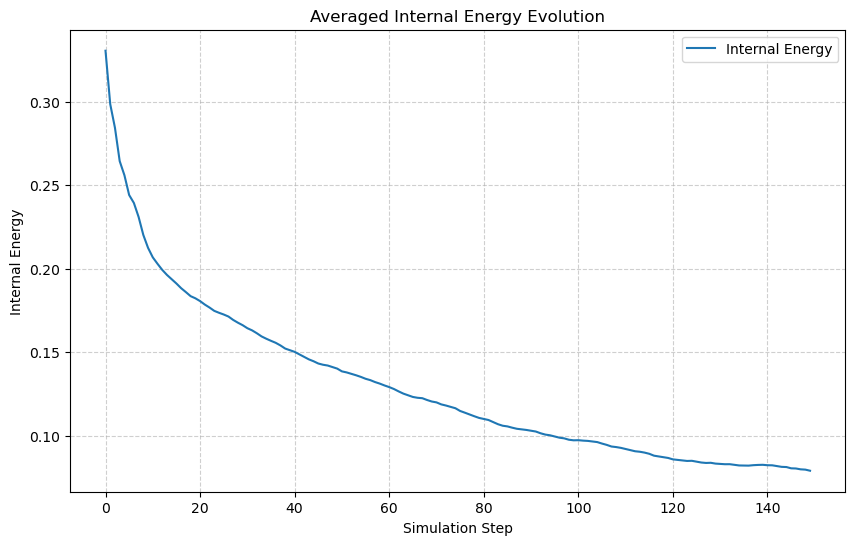

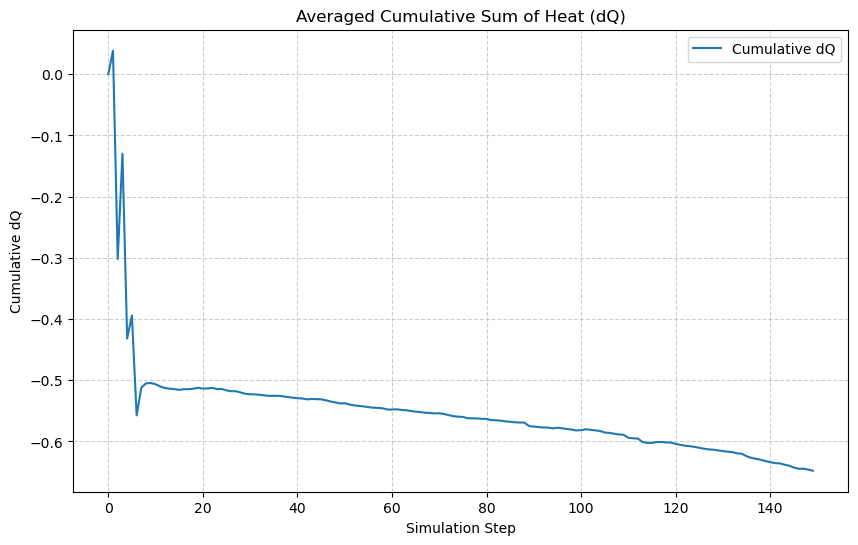

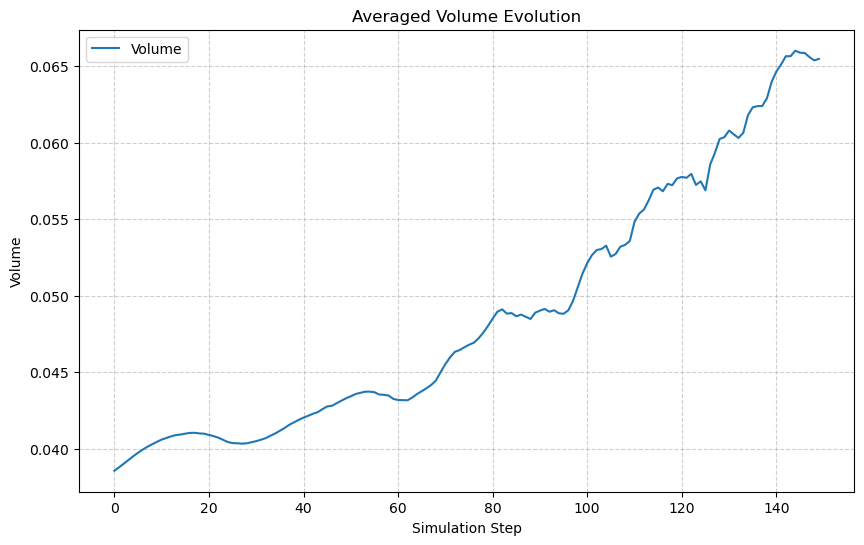

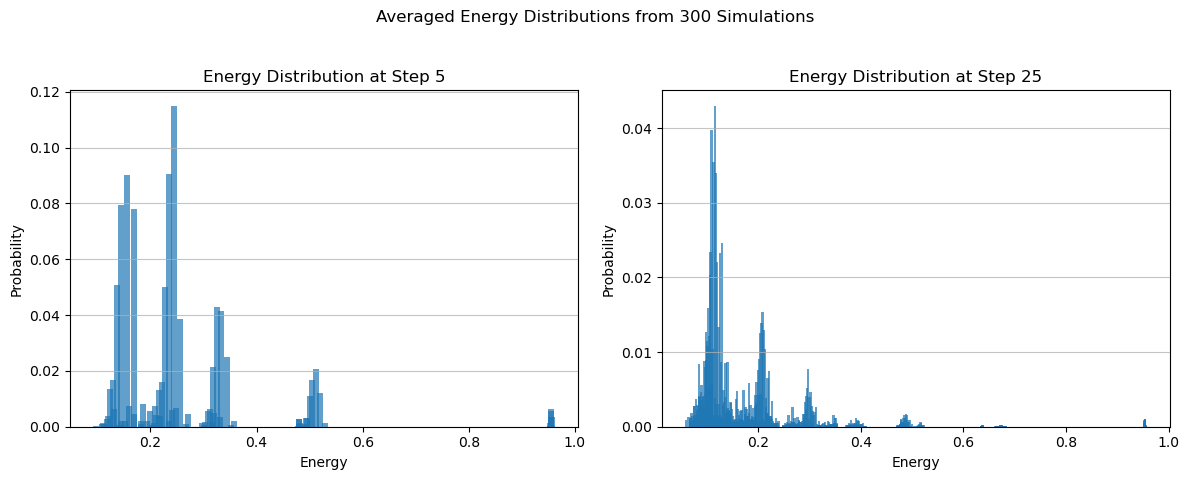

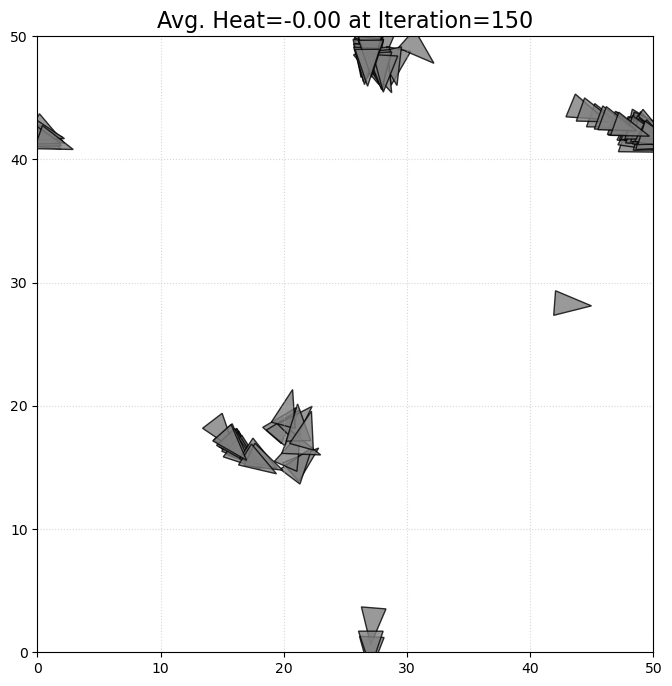

Training Gaussian Mixture Model with 3 clusters...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Adjusting GMM: High average energy observed, potentially indicating a less cohesive state.

Gaussian Mixture Model training completed successfully on averaged data!


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


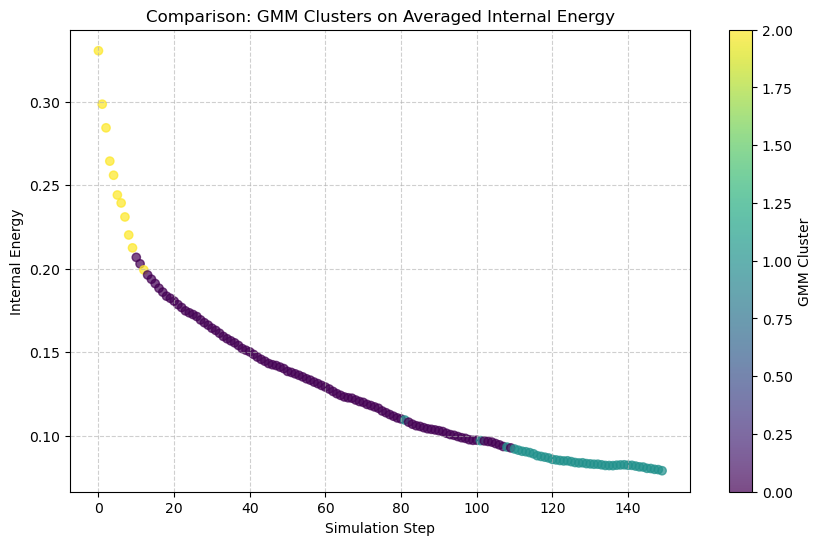

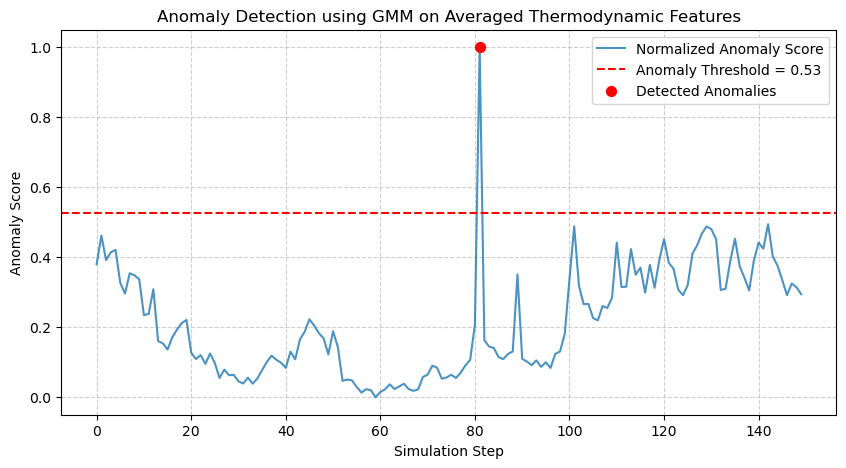

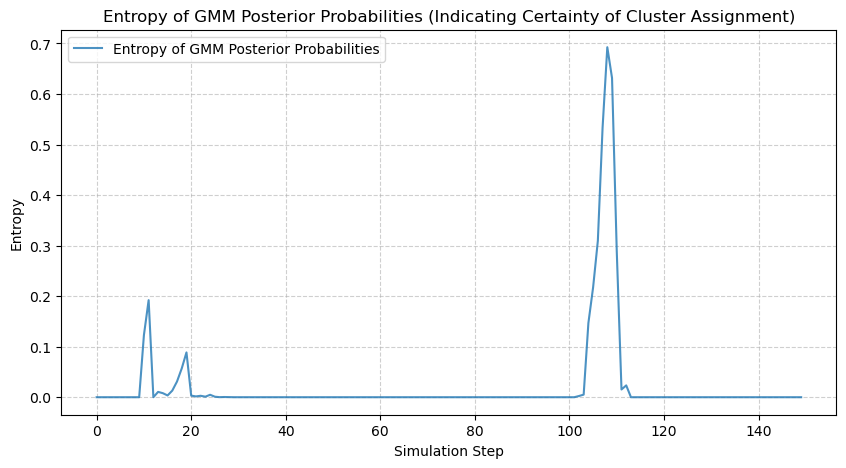

In [46]:
# =============================================================================
# --- Main Simulation Runner and Averaging Over Multiple Runs ---
# =============================================================================

if __name__ == "__main__":
    num_simulations = 300 # Number of independent simulation runs to average
    step_num = 150       # Number of steps for each simulation run
    
    # Define which agent attributes and model-level functions to record
    agent_data_funcs = ["separation", "speed", "ensemble"]
    model_data_funcs = [Step_Num, Model_Ensemble_Energy, Model_Thermo_State, 
                        Flock_Model_State, Model_Volume, Model_Internal_Energy]

    # Initialize accumulators for summing data across multiple simulation runs
    energy_sums = np.zeros(step_num)
    S_sums = np.zeros(step_num)
    T_sums = np.zeros(step_num)
    dQ_sums = np.zeros(step_num)
    V_sums = np.zeros(step_num)
    U_sums = np.zeros(step_num)
    # Initialize e_p_sums as a list of empty lists, one for each step, to accumulate (E,p) tuples
    e_p_sums = [[] for _ in range(step_num)]

    print("Starting multiple simulation runs for statistical averaging...")
    for i in range(1, num_simulations + 1):
        print(f"Running simulation {i}/{num_simulations}...")
        # Re-initialize model for each run with a unique seed for independent randomness
        current_model = Model(seed=1234 + i) 
        # Reset the global entropy variable for each new simulation run
        # This ensures dQ is calculated correctly from the start of each run.
        S_prev_global = None 
        
        # Run the simulation and get data for the current run
        _, model_data_temp = run_simulation(current_model, step_num, agent_data_funcs, model_data_funcs)
        model_df_temp = pd.DataFrame(model_data_temp)
        
        # Accumulate data from the current run
        energy_sums += model_df_temp["Model_Ensemble_Energy"].to_numpy()
        S_sums += model_df_temp["Model_Thermo_State"].apply(lambda x: x["S"]).to_numpy()
        T_sums += model_df_temp["Model_Thermo_State"].apply(lambda x: x["T"]).to_numpy()
        dQ_sums += model_df_temp["Model_Thermo_State"].apply(lambda x: x["dQ"]).to_numpy()
        V_sums += model_df_temp["Model_Volume"].to_numpy()
        U_sums += model_df_temp["Model_Internal_Energy"].to_numpy()
        
        # Extract and merge energy probability distributions
        ep_tmp = model_df_temp["Model_Thermo_State"].apply(lambda x: x["e_p_array"]).tolist()
        e_p_sums = merge_e_p_array(ep_tmp, e_p_sums)

    # Compute averages by dividing sums by the number of simulations
    average_energy = energy_sums / num_simulations
    average_S = S_sums / num_simulations
    average_T = T_sums / num_simulations
    average_dQ = dQ_sums / num_simulations
    average_V = V_sums / num_simulations
    average_U = U_sums / num_simulations
    average_e_p_array = normalize_e_p_array(e_p_sums) # Normalize merged distributions

    print("\nSimulation and averaging complete. Generating plots for averaged data...")

    # Plot the averaged thermodynamic evolution curves
    plot_internal_energy(average_U, title_prefix="Averaged ")
    plot_cumsum_dQ(average_dQ, title_prefix="Averaged ")
    plot_volume(average_V, title_prefix="Averaged ")

    # --- Plot Histograms of the Merged Energy Distributions at Specific Steps ---
    # Select two distinct simulation steps for histogram visualization
    step_idx1 = 4    # Corresponds to simulation step 5 (0-indexed)
    step_idx2 = 24   # Corresponds to simulation step 25 (0-indexed)

    # Extract energy values and their probabilities for the selected steps
    energies_step1 = [E for (E, p) in average_e_p_array[step_idx1]]
    probabilities_step1 = [p for (E, p) in average_e_p_array[step_idx1]]

    energies_step2 = [E for (E, p) in average_e_p_array[step_idx2]]
    probabilities_step2 = [p for (E, p) in average_e_p_array[step_idx2]]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    # Use bar plot to represent discrete energy distributions from histogram bins
    width1 = (energies_step1[1] - energies_step1[0]) if len(energies_step1) > 1 else 0.1
    plt.bar(energies_step1, probabilities_step1, width=width1, align='center', alpha=0.7)
    plt.title(f"Energy Distribution at Step {step_idx1 + 1}")
    plt.xlabel("Energy")
    plt.ylabel("Probability")
    plt.grid(axis='y', alpha=0.75)

    plt.subplot(1, 2, 2)
    width2 = (energies_step2[1] - energies_step2[0]) if len(energies_step2) > 1 else 0.1
    plt.bar(energies_step2, probabilities_step2, width=width2, align='center', alpha=0.7)
    plt.title(f"Energy Distribution at Step {step_idx2 + 1}")
    plt.xlabel("Energy")
    plt.ylabel("Probability")
    plt.grid(axis='y', alpha=0.75)

    plt.suptitle(f"Averaged Energy Distributions from {num_simulations} Simulations")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

    # Plot an example of bird visualization from the last simulation run
    # This helps visualize the flock's state at a specific point.
    plot_birds_iter(current_model, heat_tmp=average_dQ[-1], iteration_tmp=current_model.iteration)

    # =============================================================================
    # --- GMM Analysis on Averaged Thermodynamic Data ---
    # =============================================================================

    # Create a DataFrame from the averaged model data for GMM analysis
    averaged_model_data_df = pd.DataFrame({
        "Model_Ensemble_Energy": average_energy,
        "Model_Thermo_State": [{"S": s, "T": t, "dQ": dq, "e_p_array": e_p} 
                               for s, t, dq, e_p in zip(average_S, average_T, average_dQ, average_e_p_array)],
        "Model_Volume": average_V,
        "Model_Internal_Energy": average_U
    })
    
    # Extract features for GMM training from the averaged data
    features = extract_features_from_model_df(averaged_model_data_df)
    
    # Train the Gaussian Mixture Model on the averaged features
    num_clusters = 3 # Number of clusters can be adjusted based on data characteristics
    gmm_model = train_gmm(features, num_clusters)
    
    # Apply conceptual thermodynamic constraints to the GMM (if any adjustments are needed)
    gmm_model = enforce_thermodynamic_constraints(gmm_model, features)
    
    print("\nGaussian Mixture Model training completed successfully on averaged data!")
    
    # Get cluster labels for each simulation step based on the trained GMM
    labels = gmm_model.predict(features)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(np.arange(len(features)), average_U, c=labels, cmap='viridis', label="Thermodynamic U", alpha=0.7)
    plt.title("Comparison: GMM Clusters on Averaged Internal Energy")
    plt.xlabel("Simulation Step")
    plt.ylabel("Internal Energy")
    plt.colorbar(scatter, label="GMM Cluster")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Advanced Analysis: Anomaly Detection using GMM ---
    
    # Compute the log-likelihood of each data point (simulation step) under the GMM
    log_likelihood = gmm_model.score_samples(features) # Returns log-probabilities
    anomaly_score = -log_likelihood # Higher negative log-likelihood implies higher anomaly score
    
    # Normalize the anomaly score for easier interpretation and thresholding
    norm_anomaly_score = (anomaly_score - np.min(anomaly_score)) / (np.max(anomaly_score) - np.min(anomaly_score))
    
    # Define an anomaly threshold (e.g., mean + 2 standard deviations)
    threshold = np.mean(norm_anomaly_score) + 2 * np.std(norm_anomaly_score)
    # Identify indices of data points exceeding the anomaly threshold
    anomaly_indices = np.where(norm_anomaly_score > threshold)[0]
    
    plt.figure(figsize=(10, 5))
    plt.plot(norm_anomaly_score, label="Normalized Anomaly Score", alpha=0.8)
    plt.axhline(threshold, color='r', linestyle='--', label=f"Anomaly Threshold = {threshold:.2f}")
    plt.scatter(anomaly_indices, norm_anomaly_score[anomaly_indices], color='red', s=50, zorder=5, label="Detected Anomalies")
    plt.xlabel("Simulation Step")
    plt.ylabel("Anomaly Score")
    plt.title("Anomaly Detection using GMM on Averaged Thermodynamic Features")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig("GMM_Anomaly_Detection.png")
    plt.show()
    
    # Compute the entropy of the GMM posterior probabilities
    # This indicates the certainty of cluster assignment: higher entropy means less certain.
    posterior = gmm_model.predict_proba(features) # Posterior probabilities for each sample and cluster
    # Add a small epsilon for numerical stability with log(0)
    posterior_entropy = -np.sum(posterior * np.log(posterior + 1e-9), axis=1) 
    
    plt.figure(figsize=(10, 5))
    plt.plot(posterior_entropy, label="Entropy of GMM Posterior Probabilities", alpha=0.8)
    plt.xlabel("Simulation Step")
    plt.ylabel("Entropy")
    plt.title("Entropy of GMM Posterior Probabilities (Indicating Certainty of Cluster Assignment)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig("GMM_Posterior_Entropy.png")
    plt.show()


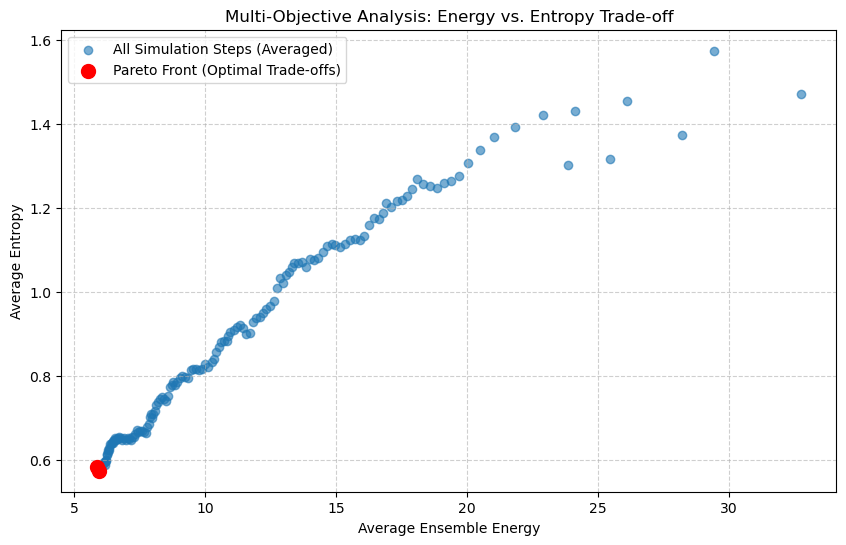

In [48]:
# ------------------------------------------------------------------------------
# Multi-Objective Analysis: Energy vs. Entropy Trade-off
# ------------------------------------------------------------------------------

def pareto_front(points):
    """
    Computes the Pareto front of a set of points, assuming both objectives are to be minimized.

    Args:
        points (np.array): An array of shape (n_points, 2), where each row is a point
                           with two objective values.

    Returns:
        tuple: (pareto_efficient_points, pareto_indices)
            pareto_efficient_points (np.array): The points on the Pareto front.
            pareto_indices (np.array): The original indices of the Pareto-efficient points.
    """
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:  # Only consider points that are still efficient
            # Check if any other point dominates the current point
            is_efficient[is_efficient] = np.any(points[is_efficient] < c, axis=1)
            is_efficient[i] = True  # Ensure the current point is kept if it's efficient itself
    return points[is_efficient], np.where(is_efficient)[0]

# Construct the points array from the averaged energy and entropy over simulation steps
points = np.column_stack((average_energy, average_S))
pareto_points, pareto_indices = pareto_front(points)

plt.figure(figsize=(10, 6))
plt.scatter(average_energy, average_S, label="All Simulation Steps (Averaged)", alpha=0.6)
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], color='red', s=100, zorder=5, label="Pareto Front (Optimal Trade-offs)")
plt.xlabel("Average Ensemble Energy")
plt.ylabel("Average Entropy")
plt.title("Multi-Objective Analysis: Energy vs. Entropy Trade-off")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("Pareto_Energy_Entropy.png")
plt.show()


--- Applying Entropy-Regularized EM on Averaged Thermodynamic Features ---


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Entropy-Regularized EM converged at iteration 36


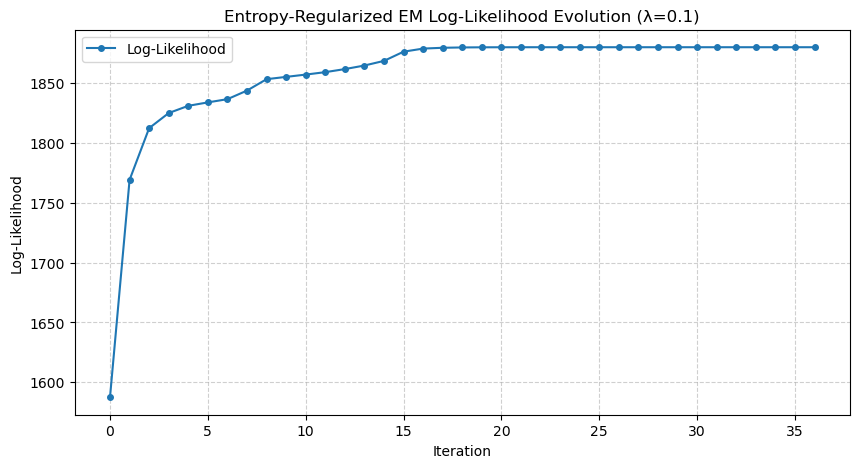

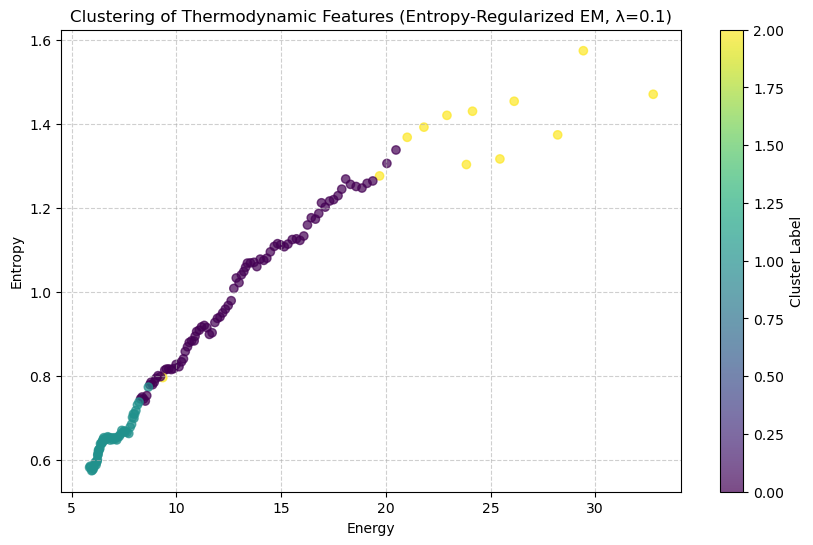

In [49]:
# -------------------------------------------------------------------------------
# Entropy-Regularized EM for GMM (Advanced Analysis)
# -------------------------------------------------------------------------------

def entropy_regularized_EM(X, num_components, lambda_reg=0.5, max_iter=200, tol=1e-5):
        """
        Implements an entropy-regularized Expectation-Maximization (EM) algorithm for GMM.
        This variant modifies the M-step for mixing coefficients by adding an entropy term,
        which can lead to more robust clustering less sensitive to initialization.
        
        Args:
            X (np.array): Input data array of shape (n_samples, n_features).
            num_components (int): Number of Gaussian components (K).
            lambda_reg (float): Regularization parameter (λ) controlling the entropy term.
                                When lambda_reg=0, the update reduces to standard EM.
            max_iter (int): Maximum number of iterations for the EM algorithm.
            tol (float): Tolerance for convergence (change in log-likelihood).
        
        Returns:
            dict: A dictionary containing the learned parameters and convergence history:
                'pi': mixing coefficients (1D array)
                'mu': means (array of shape (K, n_features))
                'cov': covariances (array of shape (K, n_features, n_features))
                'log_likelihoods': list of log-likelihood values over iterations
                'responsibilities': final responsibility matrix (n_samples x K)
        """
        n_samples, n_features = X.shape
        
        # Initialize means using MiniBatchKMeans for better stability
        kmeans = MiniBatchKMeans(n_clusters=num_components, random_state=42, n_init=10)
        kmeans.fit(X)
        mu = kmeans.cluster_centers_

        # Initialize covariances as scaled identity matrices or sample covariance
        cov = np.array([np.cov(X.T) + 1e-6*np.eye(n_features) for _ in range(num_components)])
        
        # Initialize mixing coefficients uniformly
        pi = np.ones(num_components) / num_components
        
        log_likelihoods = []
        
        for iteration in range(max_iter):
            # ----- E-step: Compute responsibilities (gamma_nk) -----
            resp = np.zeros((n_samples, num_components))
            for k in range(num_components):
                try:
                    # Calculate multivariate normal probability density for each data point
                    diff = X - mu[k]
                    inv_cov = np.linalg.inv(cov[k])
                    det_cov = np.linalg.det(cov[k])
                    
                    # Handle potential numerical issues with determinant
                    if det_cov <= 0:
                        det_cov = 1e-9 # Small positive value to avoid errors
                    
                    norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov)
                    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
                    resp[:, k] = pi[k] * norm_const * np.exp(exponent)
                except np.linalg.LinAlgError:
                    print(f"Singular covariance matrix encountered for component {k} in E-step. Adding jitter and retrying.")
                    cov[k] += 1e-6 * np.eye(n_features) # Add jitter to covariance
                    # Re-run current component's E-step calculation
                    diff = X - mu[k]
                    inv_cov = np.linalg.inv(cov[k])
                    det_cov = np.linalg.det(cov[k])
                    if det_cov <= 0: det_cov = 1e-9
                    norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov)
                    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
                    resp[:, k] = pi[k] * norm_const * np.exp(exponent)

            resp_sum = np.sum(resp, axis=1, keepdims=True)
            # Normalize responsibilities; add epsilon to avoid division by zero
            resp = resp / (resp_sum + 1e-9) 
            
            # ----- M-step: Update parameters (pi, mu, cov) -----
            N_k = np.sum(resp, axis=0)  # Effective number of points assigned to each component
            
            # Update means (mu_k)
            mu_new = np.zeros_like(mu)
            for k in range(num_components):
                if N_k[k] > 1e-9: # Only update if effective count is non-zero
                    mu_new[k] = np.sum(resp[:, k][:, np.newaxis] * X, axis=0) / N_k[k]
            mu = mu_new
            
            # Update covariances (cov_k)
            cov_new = np.zeros_like(cov)
            for k in range(num_components):
                if N_k[k] > 1e-9:
                    diff = X - mu[k]
                    cov_new[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
                    cov_new[k] += 1e-6 * np.eye(n_features)  # Add regularization for stability
            cov = cov_new
            
            # Update mixing coefficients (pi_k) with entropy regularization:
            # pi_k = (N_k)^(1/(1+λ)) / Σ_j (N_j)^(1/(1+λ))
            exponent_val = 1.0 / (1.0 + lambda_reg)
            pi_new = N_k ** exponent_val
            pi_new = pi_new / np.sum(pi_new) # Normalize to sum to 1
            pi = pi_new
            
            # Compute the log-likelihood of the data given the current parameters
            current_log_likelihood = 0.0
            for i in range(n_samples):
                temp_sum = 0.0
                for k in range(num_components):
                    try:
                        # Re-calculate PDF for log-likelihood summation
                        diff_i = X[i] - mu[k]
                        inv_cov_k = np.linalg.inv(cov[k])
                        det_cov_k = np.linalg.det(cov[k])
                        
                        if det_cov_k <= 0: 
                            det_cov_k = 1e-9
                        
                        norm_const_i = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov_k)
                        temp_sum += pi[k] * norm_const_i * np.exp(-0.5 * diff_i.T @ inv_cov_k @ diff_i)
                    except np.linalg.LinAlgError:
                        temp_sum += 1e-9 # Add small value if covariance becomes singular
                current_log_likelihood += np.log(temp_sum + 1e-9) # Add epsilon to avoid log(0)
            log_likelihoods.append(current_log_likelihood)
            
            # Check for convergence based on change in log-likelihood
            if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                print(f"Entropy-Regularized EM converged at iteration {iteration}")
                break
        
        return {
            "pi": pi,
            "mu": mu,
            "cov": cov,
            "log_likelihoods": log_likelihoods,
            "responsibilities": resp
        }

print("\n--- Applying Entropy-Regularized EM on Averaged Thermodynamic Features ---")

# Run the entropy-regularized EM algorithm on the averaged features
lambda_reg = 0.1 # Regularization strength (adjust to control entropy influence)
num_components = 3
em_result = entropy_regularized_EM(features, num_components, lambda_reg=lambda_reg, max_iter=200)

# Plot the log-likelihood evolution of the entropy-regularized EM
plt.figure(figsize=(10, 5))
plt.plot(em_result["log_likelihoods"], marker='o', linestyle='-', markersize=4, label="Log-Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title(f"Entropy-Regularized EM Log-Likelihood Evolution (λ={lambda_reg})")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig("EntropyRegularizedEM_LogLikelihood.png")
plt.show()

# Visualize the clustering results from entropy-regularized EM
cluster_labels_em = np.argmax(em_result["responsibilities"], axis=1)
plt.figure(figsize=(10, 6))
scatter_em = plt.scatter(features[:, 0], features[:, 1], c=cluster_labels_em, cmap='viridis', alpha=0.7)
plt.xlabel("Energy")
plt.ylabel("Entropy")
plt.title(f"Clustering of Thermodynamic Features (Entropy-Regularized EM, λ={lambda_reg})")
plt.colorbar(scatter_em, label="Cluster Label")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("EntropyRegularizedEM_Clustering.png")
plt.show()


--- Running sensitivity analysis for 5 runs ---


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 36


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 36


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 36


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 36


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 36


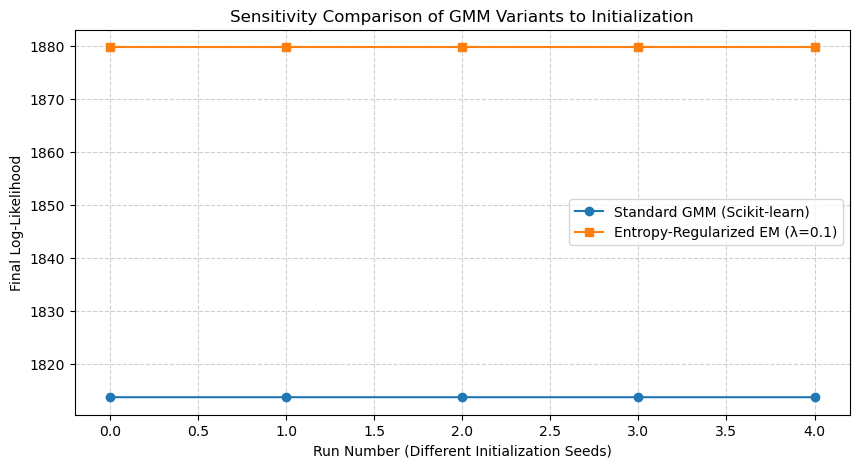


Entropy-Regularized EM Mixing Coefficients: [0.53471777 0.37261007 0.09267217]
Entropy-Regularized EM Means (first 5 features for brevity):
[[ 1.30657935e+01  9.98023180e-01  7.51531159e-02 -7.72037726e-04
   4.37704869e-02]
 [ 6.86965698e+00  6.45079329e-01  1.36843744e-01 -1.35353650e-03
   5.81020711e-02]
 [ 2.37313162e+01  1.34719103e+00  7.90623627e-01 -4.24112175e-02
   4.04467955e-02]]


In [50]:
# -------------------------------------------------------------------------------
# Sensitivity Analysis: Comparing Standard GMM vs. Entropy-Regularized EM
# -------------------------------------------------------------------------------
    
std_gmm_log_likelihoods = []
reg_em_log_likelihoods = []
num_runs_sensitivity = 5 # Number of independent runs for sensitivity comparison

print(f"\n--- Running sensitivity analysis for {num_runs_sensitivity} runs ---")
for seed_val in range(num_runs_sensitivity):
# Run Standard GMM from scikit-learn
    gmm_std_comp = GaussianMixture(n_components=num_components, covariance_type='full', max_iter=200, random_state=seed_val, n_init=10)
    gmm_std_comp.fit(features)
    # score() returns the average log-likelihood per sample; multiply by n_samples for total log-likelihood
    std_gmm_log_likelihoods.append(gmm_std_comp.score(features) * features.shape[0])
        
    # Run Entropy-Regularized EM with the same seed for comparison
    np.random.seed(seed_val) # Set seed for initialization randomness within EM
    em_res_comp = entropy_regularized_EM(features, num_components, lambda_reg=lambda_reg, max_iter=200)
    reg_em_log_likelihoods.append(em_res_comp["log_likelihoods"][-1]) # Use the final log-likelihood

plt.figure(figsize=(10, 5))
plt.plot(range(num_runs_sensitivity), std_gmm_log_likelihoods, 'o-', label="Standard GMM (Scikit-learn)")
plt.plot(range(num_runs_sensitivity), reg_em_log_likelihoods, 's-', label=f"Entropy-Regularized EM (λ={lambda_reg})")
plt.xlabel("Run Number (Different Initialization Seeds)")
plt.ylabel("Final Log-Likelihood")
plt.title("Sensitivity Comparison of GMM Variants to Initialization")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("GMM_Sensitivity_Comparison.png")
plt.show()

print("\nEntropy-Regularized EM Mixing Coefficients:", em_result["pi"])
print("Entropy-Regularized EM Means (first 5 features for brevity):")
# Print only the first 5 features of the means for conciseness
print(em_result["mu"][:, :5]) 




--- Comparison of Different Clustering Methods ---

Running K-Means Clustering...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Running Spectral Clustering...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Running Agglomerative Clustering...
Running DBSCAN...

--- Evaluating Clustering Methods ---
  K-Means: Silhouette=0.5575, DBI=0.5544, CHI=179.0245
  Spectral Clustering: Silhouette=0.4376, DBI=0.7805, CHI=75.2030
  Agglomerative Clustering: Silhouette=0.5338, DBI=0.5411, CHI=147.4950
  DBSCAN: Not enough valid clusters or points for metrics (assigned 1 clusters).

--- Visualizing Clustering Results ---


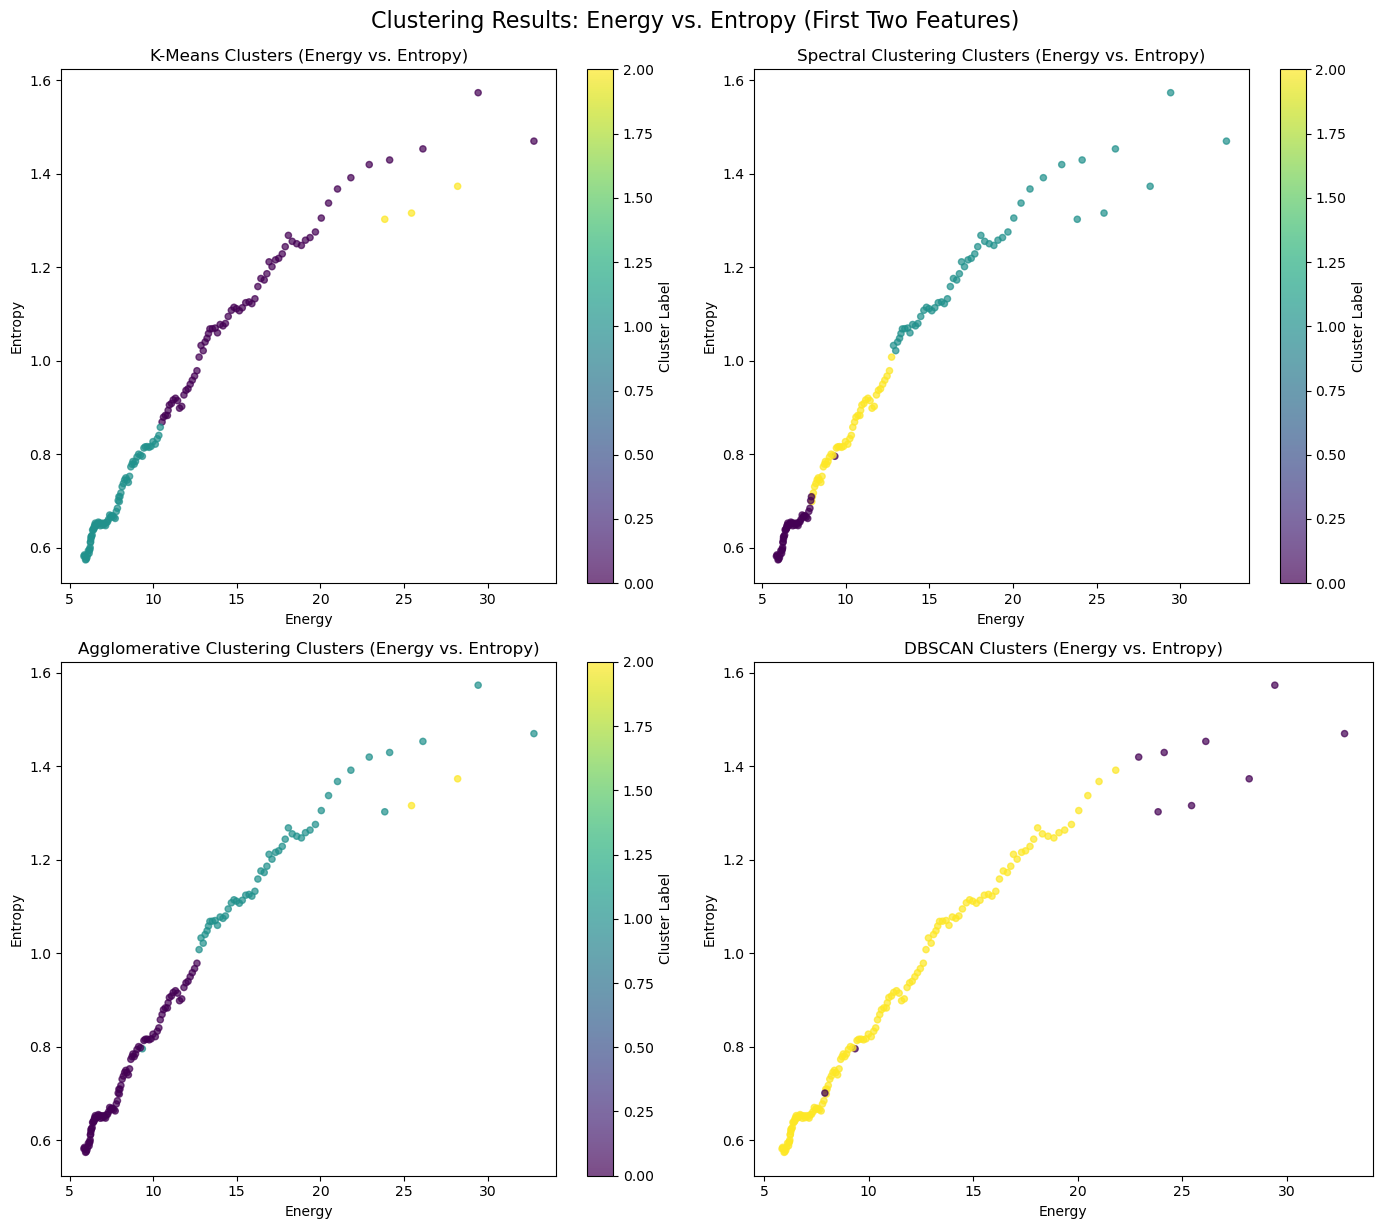

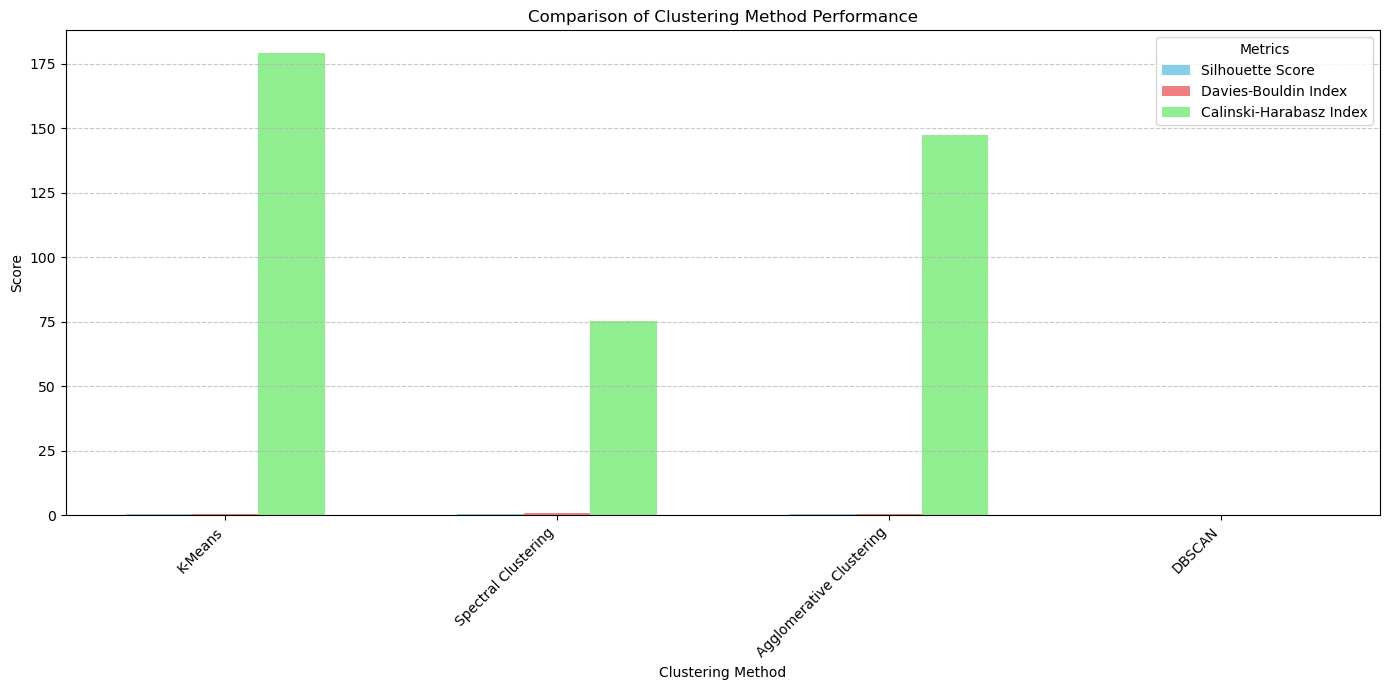

In [52]:
# New imports for comparing clustering methods
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler # For Z-score normalization in clustering preprocessing
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# =============================================================================
# --- Comparison of Different Clustering Methods ---
# =============================================================================
print("\n--- Comparison of Different Clustering Methods ---")

# Preprocessing: Standardize features for distance-based clustering methods
# This is important as different features might have different scales (e.g., Energy vs. Volume)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Define the number of clusters to use for methods that require it
# We'll use 3 clusters, consistent with the GMM analysis
n_clusters_compare = 3

# Dictionary to store results for each clustering method
clustering_results = {}

# 1. K-Means Clustering
print("\nRunning K-Means Clustering...")
kmeans = KMeans(n_clusters=n_clusters_compare, random_state=42, n_init=10) # n_init for robustness
kmeans_labels = kmeans.fit_predict(features_scaled)
clustering_results['K-Means'] = kmeans_labels

# 2. Spectral Clustering
# Spectral clustering can be computationally intensive for large datasets.
# It requires a similarity graph, often based on distances.
print("Running Spectral Clustering...")
# affinity='nearest_neighbors' is often more robust than 'rbf' for sparse data
# n_neighbors is important for affinity graph construction
spectral = SpectralClustering(n_clusters=n_clusters_compare, random_state=42, affinity='nearest_neighbors', n_neighbors=10)
# SpectralClustering returns -1 for unassigned points if n_components is too high or affinity is bad.
# It might also return fewer than n_clusters if components are disconnected.
try:
    spectral_labels = spectral.fit_predict(features_scaled)
    # Ensure labels are non-negative and sequential for metrics
    unique_labels = np.unique(spectral_labels)
    if -1 in unique_labels: # Handle noise points if present
        print("Warning: SpectralClustering found noise points (-1 label). These will be excluded from metric calculation.")
        spectral_labels_filtered = spectral_labels[spectral_labels != -1]
        features_scaled_filtered = features_scaled[spectral_labels != -1]
    else:
        spectral_labels_filtered = spectral_labels
        features_scaled_filtered = features_scaled

    if len(np.unique(spectral_labels_filtered)) < 2:
        print("Spectral Clustering resulted in less than 2 valid clusters. Metrics will be NaN.")
        clustering_results['Spectral Clustering'] = spectral_labels # Keep original labels for plotting
    else:
        clustering_results['Spectral Clustering'] = spectral_labels
except Exception as e:
    print(f"Spectral Clustering failed: {e}. Skipping metrics for this method.")
    spectral_labels = np.full(features.shape[0], -1) # Assign all to noise or single label
    clustering_results['Spectral Clustering'] = spectral_labels

# 3. Agglomerative Clustering (Hierarchical)
print("Running Agglomerative Clustering...")
agglo = AgglomerativeClustering(n_clusters=n_clusters_compare)
agglo_labels = agglo.fit_predict(features_scaled)
clustering_results['Agglomerative Clustering'] = agglo_labels

# 4. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
# DBSCAN does not require n_clusters, but requires eps and min_samples.
# These are highly dependent on data density and scale.
# Using default or reasonable values for demonstration, but tuning is crucial.
print("Running DBSCAN...")
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
# These values need careful tuning. A common starting point for eps is to look at the k-distance graph.
dbscan = DBSCAN(eps=0.5, min_samples=5) # Example values; might need tuning for your specific data
dbscan_labels = dbscan.fit_predict(features_scaled)
clustering_results['DBSCAN'] = dbscan_labels

# =============================================================================
# --- Evaluation of Clustering Methods ---
# =============================================================================
print("\n--- Evaluating Clustering Methods ---")

evaluation_metrics = {
    'Silhouette Score': {},
    'Davies-Bouldin Index': {},
    'Calinski-Harabasz Index': {}
}

for method_name, labels_predicted in clustering_results.items():
    # Filter out noise points (-1 label) for metrics calculation if they exist
    valid_indices = labels_predicted != -1
    if np.sum(valid_indices) < 2 or len(np.unique(labels_predicted[valid_indices])) < 2:
        # Not enough valid points or clusters for metrics
        evaluation_metrics['Silhouette Score'][method_name] = np.nan
        evaluation_metrics['Davies-Bouldin Index'][method_name] = np.nan
        evaluation_metrics['Calinski-Harabasz Index'][method_name] = np.nan
        print(f"  {method_name}: Not enough valid clusters or points for metrics (assigned {len(np.unique(labels_predicted[valid_indices]))} clusters).")
        continue
    
    features_valid = features_scaled[valid_indices]
    labels_valid = labels_predicted[valid_indices]

    try:
        evaluation_metrics['Silhouette Score'][method_name] = silhouette_score(features_valid, labels_valid)
    except Exception as e:
        evaluation_metrics['Silhouette Score'][method_name] = np.nan
        print(f"  {method_name} Silhouette Score failed: {e}")

    try:
        evaluation_metrics['Davies-Bouldin Index'][method_name] = davies_bouldin_score(features_valid, labels_valid)
    except Exception as e:
        evaluation_metrics['Davies-Bouldin Index'][method_name] = np.nan
        print(f"  {method_name} Davies-Bouldin Index failed: {e}")

    try:
        evaluation_metrics['Calinski-Harabasz Index'][method_name] = calinski_harabasz_score(features_valid, labels_valid)
    except Exception as e:
        evaluation_metrics['Calinski-Harabasz Index'][method_name] = np.nan
        print(f"  {method_name} Calinski-Harabasz Index failed: {e}")
    
    print(f"  {method_name}: Silhouette={evaluation_metrics['Silhouette Score'][method_name]:.4f}, "
            f"DBI={evaluation_metrics['Davies-Bouldin Index'][method_name]:.4f}, "
            f"CHI={evaluation_metrics['Calinski-Harabasz Index'][method_name]:.4f}")

# =============================================================================
# --- Visualization of Clustering Results ---
# =============================================================================
print("\n--- Visualizing Clustering Results ---")

# Plotting Energy vs. Entropy (first two features) for each clustering method
# Ensure features has at least 2 columns for this visualization
if features.shape[1] >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten() # Flatten to easily iterate

    plot_idx = 0
    for method_name, labels_predicted in clustering_results.items():
        ax = axes[plot_idx]
        scatter = ax.scatter(features[:, 0], features[:, 1], c=labels_predicted, cmap='viridis', s=20, alpha=0.7)
        ax.set_title(f'{method_name} Clusters (Energy vs. Entropy)')
        ax.set_xlabel('Energy')
        ax.set_ylabel('Entropy')
        
        # Add colorbar if there are actual clusters (not just noise)
        if len(np.unique(labels_predicted[labels_predicted != -1])) > 1:
            plt.colorbar(scatter, ax=ax, label='Cluster Label')
        
        plot_idx += 1
    
    plt.tight_layout()
    plt.suptitle("Clustering Results: Energy vs. Entropy (First Two Features)", y=1.02, fontsize=16)
    plt.savefig("Clustering_Comparison_Plots.png")
    plt.show()
else:
    print("Cannot plot 2D cluster visualization: 'features' has less than 2 dimensions.")

# Bar chart for comparing metrics
fig, ax = plt.subplots(figsize=(14, 7))

metric_names = list(evaluation_metrics.keys())
method_names = list(clustering_results.keys())

bar_width = 0.2
index = np.arange(len(method_names))

colors = ['skyblue', 'lightcoral', 'lightgreen'] # Colors for metrics

for i, metric in enumerate(metric_names):
    metric_values = [evaluation_metrics[metric][method] for method in method_names]
    # Replace NaN with 0 for plotting purposes (or handle as desired)
    metric_values_plot = [0 if np.isnan(val) else val for val in metric_values]
    ax.bar(index + i * bar_width - (len(metric_names) - 1) * bar_width / 2, 
            metric_values_plot, bar_width, label=metric, color=colors[i])

ax.set_xlabel('Clustering Method')
ax.set_ylabel('Score')
ax.set_title('Comparison of Clustering Method Performance')
ax.set_xticks(index)
ax.set_xticklabels(method_names, rotation=45, ha='right')
ax.legend(title="Metrics")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Clustering_Metrics_Comparison.png")
plt.show()

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.cluster import MiniBatchKMeans # For robust GMM initialization
import time # Added for performance timing
from sklearn.metrics import silhouette_score # Added for clustering evaluation


--- Model Evaluation and Comparison ---

Evaluating Standard GMM...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Evaluating Entropy-Regularized GMM...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Entropy-Regularized EM converged at iteration 27

--- Evaluation Results ---
Standard GMM:
  Final Log-Likelihood: 1411.9393
  BIC: -2513.2192
  AIC: -2699.8786
  Silhouette Score: 0.6079
  Computational Time (s): 1.2495

Entropy-Regularized GMM:
  Final Log-Likelihood: 1412.0170
  BIC (approx): -2513.3747
  AIC (approx): -2700.0341
  Silhouette Score: 0.6032
  Computational Time (s): 1.7473


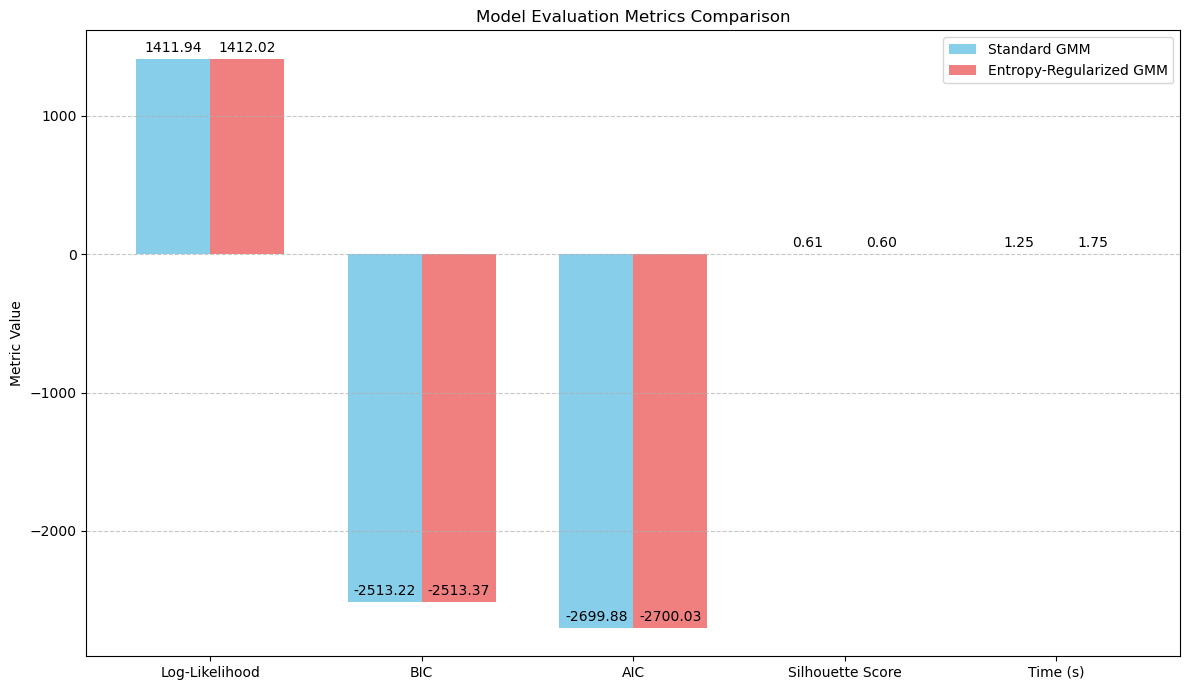

In [ ]:
# =============================================================================
# --- New Section: Model Evaluation and Comparison ---
# =============================================================================
print("\n--- Model Evaluation and Comparison ---")

# Set parameters for GMMs
num_components_eval = 3 # Number of components for evaluation
lambda_reg_eval = 0.1   # Entropy regularization parameter for evaluation

# Get the number of samples and features from the 'features' data
n_samples, n_features = features.shape

# -------------------------------
# Standard GMM Evaluation (scikit-learn)
# -------------------------------
print("\nEvaluating Standard GMM...")
start_std = time.time()
gmm_std = GaussianMixture(n_components=num_components_eval, covariance_type='full', random_state=42, n_init=10)
gmm_std.fit(features)
std_time = time.time() - start_std

std_log_likelihood = gmm_std.score(features) * n_samples  # total log-likelihood
std_bic = gmm_std.bic(features)
std_aic = gmm_std.aic(features)
std_labels = gmm_std.predict(features)
# Calculate silhouette score only if there is more than one unique cluster
std_silhouette = silhouette_score(features, std_labels) if len(np.unique(std_labels)) > 1 else np.nan

# -------------------------------
# Entropy-Regularized GMM Evaluation
# -------------------------------
print("Evaluating Entropy-Regularized GMM...")
start_reg = time.time()
# Use the existing entropy_regularized_EM function
em_result_eval = entropy_regularized_EM(features, num_components_eval, lambda_reg=lambda_reg_eval, max_iter=200)
reg_time = time.time() - start_reg

reg_log_likelihood = em_result_eval["log_likelihoods"][-1]
    
# For our custom method, we compute approximate BIC and AIC.
# Number of free parameters p for a GMM is approximated as:
# p = (K - 1) + K*d + K*d*(d+1)/2, where K = num_components, d = n_features.
# K-1 for mixing coefficients, K*d for means, K*d*(d+1)/2 for full covariance matrices.
p_params = (num_components_eval - 1) + num_components_eval * n_features + num_components_eval * n_features * (n_features + 1) / 2
reg_bic = -2 * reg_log_likelihood + p_params * np.log(n_samples)
reg_aic = -2 * reg_log_likelihood + 2 * p_params

reg_labels = np.argmax(em_result_eval["responsibilities"], axis=1)
# Calculate silhouette score only if there is more than one unique cluster
reg_silhouette = silhouette_score(features, reg_labels) if len(np.unique(reg_labels)) > 1 else np.nan

# -------------------------------
# Print Evaluation Metrics
# -------------------------------
print("\n--- Evaluation Results ---")
print("Standard GMM:")
print(f"  Final Log-Likelihood: {std_log_likelihood:.4f}")
print(f"  BIC: {std_bic:.4f}")
print(f"  AIC: {std_aic:.4f}")
print(f"  Silhouette Score: {std_silhouette:.4f}")
print(f"  Computational Time (s): {std_time:.4f}")
print()
print("Entropy-Regularized GMM:")
print(f"  Final Log-Likelihood: {reg_log_likelihood:.4f}")
print(f"  BIC (approx): {reg_bic:.4f}")
print(f"  AIC (approx): {reg_aic:.4f}")
print(f"  Silhouette Score: {reg_silhouette:.4f}")
print(f"  Computational Time (s): {reg_time:.4f}")

# -------------------------------
# Plotting Comparison Metrics
# -------------------------------
metrics_names = ["Log-Likelihood", "BIC", "AIC", "Silhouette Score", "Time (s)"]
std_metrics = [std_log_likelihood, std_bic, std_aic, std_silhouette, std_time]
reg_metrics = [reg_log_likelihood, reg_bic, reg_aic, reg_silhouette, reg_time]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, std_metrics, width, label='Standard GMM', color='skyblue')
rects2 = ax.bar(x + width/2, reg_metrics, width, label='Entropy-Regularized GMM', color='lightcoral')

ax.set_ylabel('Metric Value')
ax.set_title('Model Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        # Handle NaN values for silhouette score gracefully
        text_val = f'{height:.2f}' if not np.isnan(height) else 'NaN'
        ax.annotate(text_val,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig("GMM_Model_Evaluation_Comparison.png")
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
# -------------------------------
# Compute MSE Across All Metrics
# -------------------------------
# Convert lists to numpy arrays for element-wise operations
std_metrics_array = np.array(std_metrics)
reg_metrics_array = np.array(reg_metrics)

# Handle NaN values before computing MSE. Replace NaN with a common value (e.g., 0 or the mean)
# For silhouette score, if one is NaN and the other is not, MSE will be affected.
# A robust way is to only compare non-NaN pairs or impute. For simplicity, we'll replace NaN with 0.
# This might not be ideal for all metrics but ensures MSE calculation.
std_metrics_array[np.isnan(std_metrics_array)] = 0
reg_metrics_array[np.isnan(reg_metrics_array)] = 0

mse_all = mean_squared_error(std_metrics_array, reg_metrics_array)
print(f"\nMSE across all evaluation metrics: {mse_all:.4f}")


MSE across all evaluation metrics: 0.0604


In [31]:
# -------------------------------
# Normalization and MSE Calculation
# -------------------------------

def min_max_normalize(arr):
    """Applies Min-Max normalization to a numpy array."""
    min_val = np.min(arr)
    max_val = np.max(arr)
    if max_val == min_val: # Avoid division by zero if all values are the same
        return np.zeros_like(arr)
    return (arr - min_val) / (max_val - min_val)

def z_score_normalize(arr):
    """Applies Z-score normalization (standardization) to a numpy array."""
    mean_val = np.mean(arr)
    std_val = np.std(arr)
    if std_val == 0: # Avoid division by zero if standard deviation is zero
        return np.zeros_like(arr)
    return (arr - mean_val) / std_val

# Apply Min-Max Normalization
std_metrics_minmax = min_max_normalize(std_metrics_array)
reg_metrics_minmax = min_max_normalize(reg_metrics_array)
mse_minmax = mean_squared_error(std_metrics_minmax, reg_metrics_minmax)

# Apply Z-Score Normalization
std_metrics_z = z_score_normalize(std_metrics_array)
reg_metrics_z = z_score_normalize(reg_metrics_array)
mse_z = mean_squared_error(std_metrics_z, reg_metrics_z)

print(f"Min–Max Normalization MSE: {mse_minmax:.4f}")
print(f"Z-Score Normalization MSE: {mse_z:.4f}")

Min–Max Normalization MSE: 0.0000
Z-Score Normalization MSE: 0.0000


Training Gaussian Mixture Model with 3 clusters...
Adjusting GMM: High average energy observed, potentially indicating a less cohesive state.


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Gaussian Mixture Model training completed successfully on averaged data!


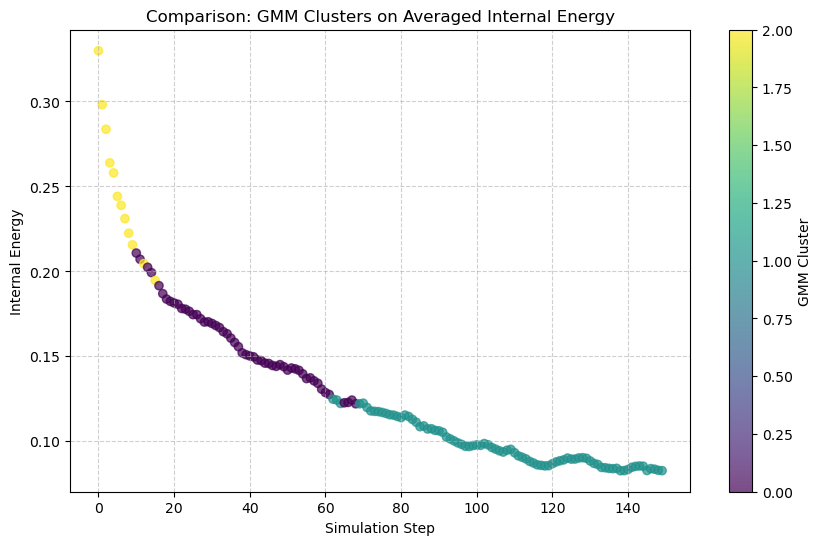

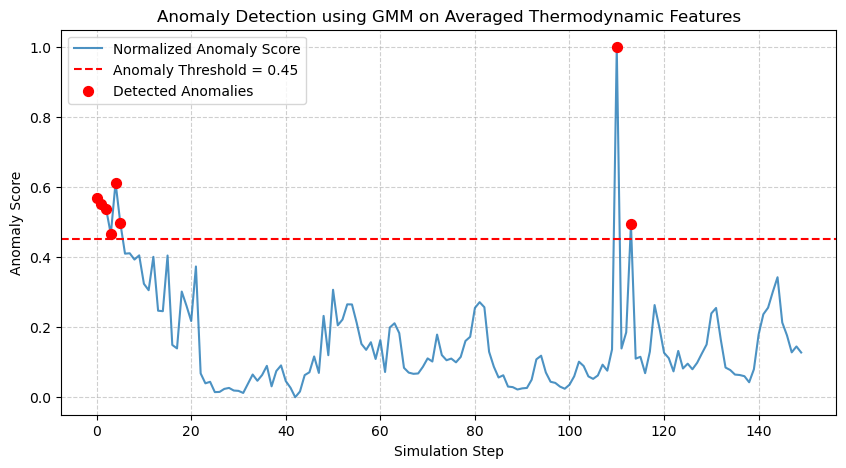

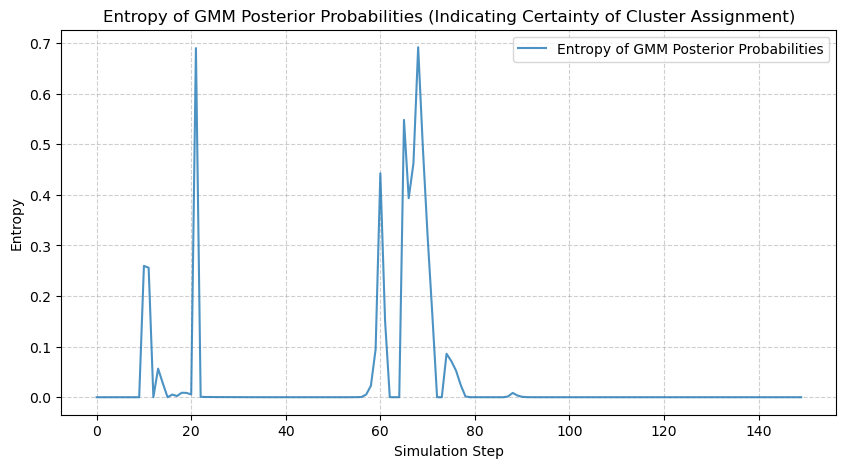

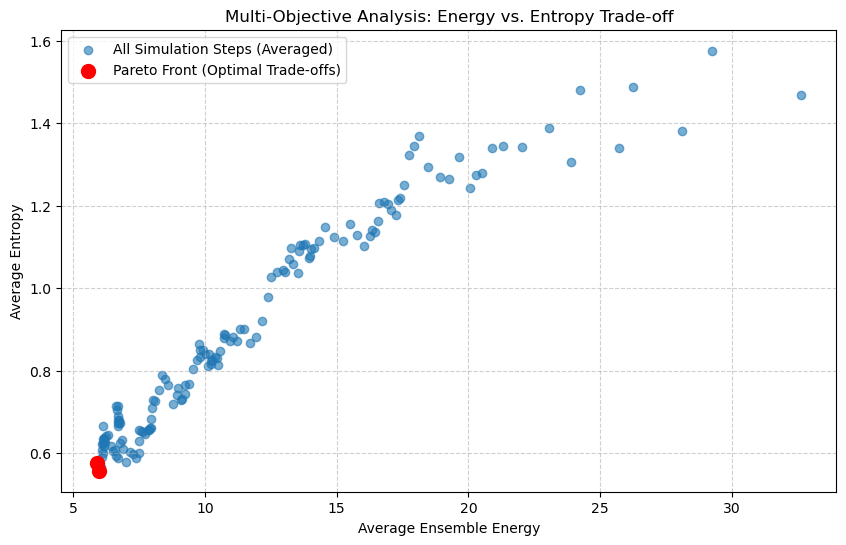


--- Applying Entropy-Regularized EM on Averaged Thermodynamic Features ---


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Entropy-Regularized EM converged at iteration 27


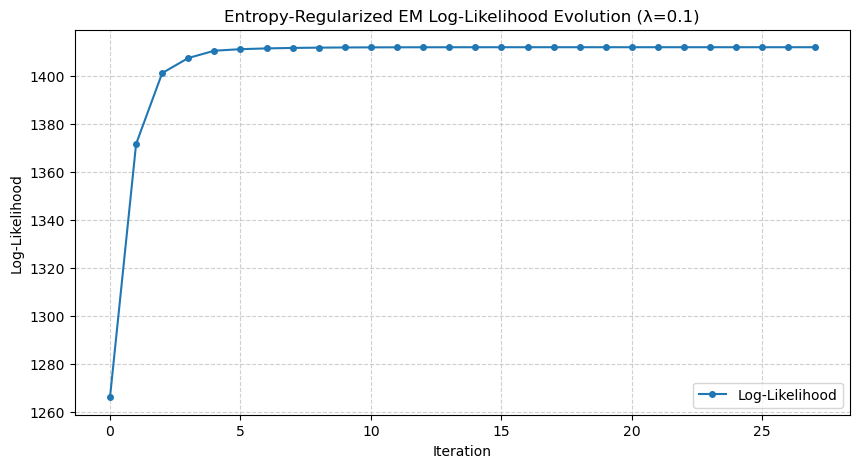

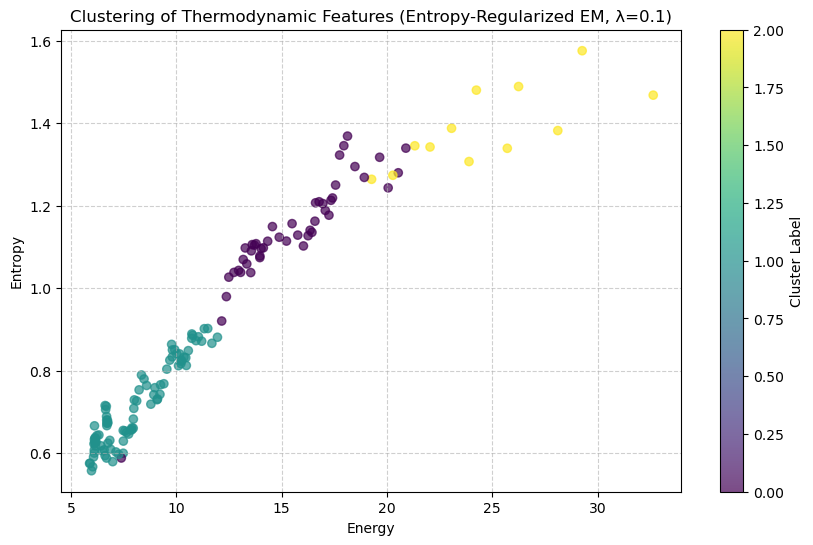


--- Running basic sensitivity analysis for 5 runs ---


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 27


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 27


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 27


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 27


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 27


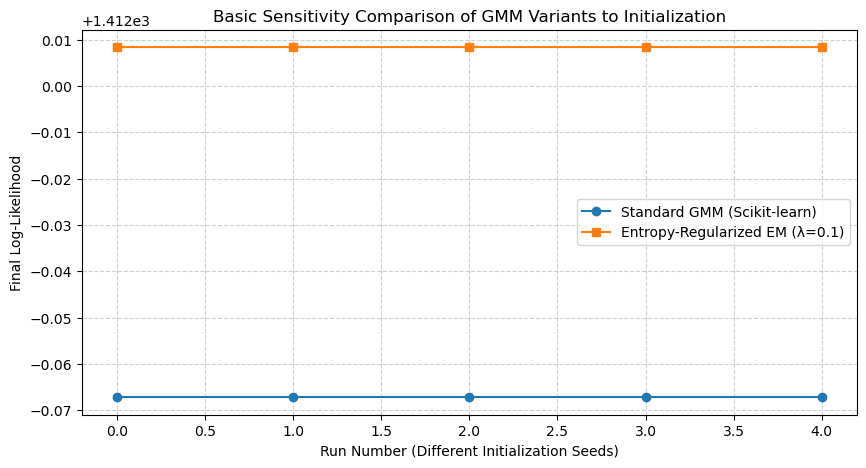


Entropy-Regularized EM Mixing Coefficients: [0.32638937 0.59242651 0.08118411]
Entropy-Regularized EM Means (first 5 features for brevity):
[[ 1.54499110e+01  1.13735252e+00  8.70974417e-02 -1.77740640e-03
   4.20866483e-02]
 [ 8.12219488e+00  7.14780821e-01  1.16129760e-01 -1.16254098e-03
   5.67449776e-02]
 [ 2.37030981e+01  1.38274889e+00  4.00602735e-01 -2.60805268e-02
   3.95400828e-02]]

--- Extended Sensitivity Analysis and Cluster Consistency ---
Run 1/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.54s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.90s
Run 2/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.53s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.89s
Run 3/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.57s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.78s
Run 4/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.60s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.75s
Run 5/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.61s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.81s
Run 6/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.63s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.76s
Run 7/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.55s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.97s
Run 8/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.53s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.75s
Run 9/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.63s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.78s
Run 10/10


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Entropy-Regularized EM converged at iteration 37
  Standard GMM LogLik: 1411.93, Silhouette: 0.61, Time: 1.58s
  Entropy-Reg GMM LogLik: 1408.95, Silhouette: 0.60, Time: 1.94s


NameError: name 'adjusted_rand_score' is not defined

In [ ]:
# =============================================================================
# --- GMM Analysis on Averaged Thermodynamic Data ---
# =============================================================================

# Create a DataFrame from the averaged model data for GMM analysis
averaged_model_data_df = pd.DataFrame({
    "Model_Ensemble_Energy": average_energy,
    "Model_Thermo_State": [{"S": s, "T": t, "dQ": dq, "e_p_array": e_p} 
                            for s, t, dq, e_p in zip(average_S, average_T, average_dQ, average_e_p_array)],
    "Model_Volume": average_V,
    "Model_Internal_Energy": average_U
})
    
# Extract features for GMM training from the averaged data
features = extract_features_from_model_df(averaged_model_data_df)
    
# Train the Gaussian Mixture Model on the averaged features
num_clusters = 3 # Number of clusters can be adjusted based on data characteristics
gmm_model = train_gmm(features, num_clusters)

# Apply conceptual thermodynamic constraints to the GMM (if any adjustments are needed)
gmm_model = enforce_thermodynamic_constraints(gmm_model, features)

print("\nGaussian Mixture Model training completed successfully on averaged data!")

# Get cluster labels for each simulation step based on the trained GMM
labels = gmm_model.predict(features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(np.arange(len(features)), average_U, c=labels, cmap='viridis', label="Thermodynamic U", alpha=0.7)
plt.title("Comparison: GMM Clusters on Averaged Internal Energy")
plt.xlabel("Simulation Step")
plt.ylabel("Internal Energy")
plt.colorbar(scatter, label="GMM Cluster")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Advanced Analysis: Anomaly Detection using GMM ---

# Compute the log-likelihood of each data point (simulation step) under the GMM
log_likelihood = gmm_model.score_samples(features) # Returns log-probabilities
anomaly_score = -log_likelihood # Higher negative log-likelihood implies higher anomaly score

# Normalize the anomaly score for easier interpretation and thresholding
norm_anomaly_score = (anomaly_score - np.min(anomaly_score)) / (np.max(anomaly_score) - np.min(anomaly_score))

# Define an anomaly threshold (e.g., mean + 2 standard deviations)
threshold = np.mean(norm_anomaly_score) + 2 * np.std(norm_anomaly_score)
# Identify indices of data points exceeding the anomaly threshold
anomaly_indices = np.where(norm_anomaly_score > threshold)[0]

plt.figure(figsize=(10, 5))
plt.plot(norm_anomaly_score, label="Normalized Anomaly Score", alpha=0.8)
plt.axhline(threshold, color='r', linestyle='--', label=f"Anomaly Threshold = {threshold:.2f}")
plt.scatter(anomaly_indices, norm_anomaly_score[anomaly_indices], color='red', s=50, zorder=5, label="Detected Anomalies")
plt.xlabel("Simulation Step")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Detection using GMM on Averaged Thermodynamic Features")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("GMM_Anomaly_Detection.png")
plt.show()

# Compute the entropy of the GMM posterior probabilities
# This indicates the certainty of cluster assignment: higher entropy means less certain.
posterior = gmm_model.predict_proba(features) # Posterior probabilities for each sample and cluster
# Add a small epsilon for numerical stability with log(0)
posterior_entropy = -np.sum(posterior * np.log(posterior + 1e-9), axis=1) 

plt.figure(figsize=(10, 5))
plt.plot(posterior_entropy, label="Entropy of GMM Posterior Probabilities", alpha=0.8)
plt.xlabel("Simulation Step")
plt.ylabel("Entropy")
plt.title("Entropy of GMM Posterior Probabilities (Indicating Certainty of Cluster Assignment)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("GMM_Posterior_Entropy.png")
plt.show()

# ------------------------------------------------------------------------------
# Multi-Objective Analysis: Energy vs. Entropy Trade-off
# ------------------------------------------------------------------------------

def pareto_front(points):
    """
    Computes the Pareto front of a set of points, assuming both objectives are to be minimized.
    
    Args:
        points (np.array): An array of shape (n_points, 2), where each row is a point
                            with two objective values.
    
    Returns:
        tuple: (pareto_efficient_points, pareto_indices)
            pareto_efficient_points (np.array): The points on the Pareto front.
            pareto_indices (np.array): The original indices of the Pareto-efficient points.
    """
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]: # Only consider points that are still efficient
            # Check if any other point dominates the current point (is better or equal in all objectives, and strictly better in at least one)
            is_efficient[is_efficient] = np.any(points[is_efficient] < c, axis=1) # True if any existing point is strictly better
            is_efficient[i] = True  # Ensure the current point is kept if it's efficient itself
    return points[is_efficient], np.where(is_efficient)[0]

# Construct the points array from the averaged energy and entropy over simulation steps
points = np.column_stack((average_energy, average_S))
pareto_points, pareto_indices = pareto_front(points)

plt.figure(figsize=(10, 6))
plt.scatter(average_energy, average_S, label="All Simulation Steps (Averaged)", alpha=0.6)
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], color='red', s=100, zorder=5, label="Pareto Front (Optimal Trade-offs)")
plt.xlabel("Average Ensemble Energy")
plt.ylabel("Average Entropy")
plt.title("Multi-Objective Analysis: Energy vs. Entropy Trade-off")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("Pareto_Energy_Entropy.png")
plt.show()

# -------------------------------------------------------------------------------
# Entropy-Regularized EM for GMM (Advanced Analysis)
# -------------------------------------------------------------------------------

def entropy_regularized_EM(X, num_components, lambda_reg=0.5, max_iter=200, tol=1e-5):
    """
    Implements an entropy-regularized Expectation-Maximization (EM) algorithm for GMM.
    This variant modifies the M-step for mixing coefficients by adding an entropy term,
    which can lead to more robust clustering less sensitive to initialization.
    
    Args:
        X (np.array): Input data array of shape (n_samples, n_features).
        num_components (int): Number of Gaussian components (K).
        lambda_reg (float): Regularization parameter (λ) controlling the entropy term.
                            When lambda_reg=0, the update reduces to standard EM.
        max_iter (int): Maximum number of iterations for the EM algorithm.
        tol (float): Tolerance for convergence (change in log-likelihood).
    
    Returns:
        dict: A dictionary containing the learned parameters and convergence history:
            'pi': mixing coefficients (1D array)
            'mu': means (array of shape (K, n_features))
            'cov': covariances (array of shape (K, n_features, n_features))
            'log_likelihoods': list of log-likelihood values over iterations
            'responsibilities': final responsibility matrix (n_samples x K)
    """
    n_samples, n_features = X.shape
    
    # Initialize means using MiniBatchKMeans for better stability
    kmeans = MiniBatchKMeans(n_clusters=num_components, random_state=42, n_init=10)
    kmeans.fit(X)
    mu = kmeans.cluster_centers_

    # Initialize covariances as scaled identity matrices or sample covariance
    cov = np.array([np.cov(X.T) + 1e-6*np.eye(n_features) for _ in range(num_components)])
    
    # Initialize mixing coefficients uniformly
    pi = np.ones(num_components) / num_components
    
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # ----- E-step: Compute responsibilities (gamma_nk) -----
        resp = np.zeros((n_samples, num_components))
        for k in range(num_components):
            try:
                # Calculate multivariate normal probability density for each data point
                diff = X - mu[k]
                inv_cov = np.linalg.inv(cov[k])
                det_cov = np.linalg.det(cov[k])
                
                # Handle potential numerical issues with determinant
                if det_cov <= 0:
                    det_cov = 1e-9 # Small positive value to avoid errors
                
                norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov)
                exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
                resp[:, k] = pi[k] * norm_const * np.exp(exponent)
            except np.linalg.LinAlgError:
                print(f"Singular covariance matrix encountered for component {k} in E-step. Adding jitter and retrying.")
                cov[k] += 1e-6 * np.eye(n_features) # Add jitter to covariance
                # Re-run current component's E-step calculation
                diff = X - mu[k]
                inv_cov = np.linalg.inv(cov[k])
                det_cov = np.linalg.det(cov[k])
                if det_cov <= 0: det_cov = 1e-9
                norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov)
                exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
                resp[:, k] = pi[k] * norm_const * np.exp(exponent)

        resp_sum = np.sum(resp, axis=1, keepdims=True)
        # Normalize responsibilities; add epsilon to avoid division by zero
        resp = resp / (resp_sum + 1e-9) 
        
        # ----- M-step: Update parameters (pi, mu, cov) -----
        N_k = np.sum(resp, axis=0)  # Effective number of points assigned to each component
        
        # Update means (mu_k)
        mu_new = np.zeros_like(mu)
        for k in range(num_components):
            if N_k[k] > 1e-9: # Only update if effective count is non-zero
                mu_new[k] = np.sum(resp[:, k][:, np.newaxis] * X, axis=0) / N_k[k]
        mu = mu_new
        
        # Update covariances (cov_k)
        cov_new = np.zeros_like(cov)
        for k in range(num_components):
            if N_k[k] > 1e-9:
                diff = X - mu[k]
                cov_new[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
                cov_new[k] += 1e-6 * np.eye(n_features)  # Add regularization for stability
        cov = cov_new
        
        # Update mixing coefficients (pi_k) with entropy regularization:
        # pi_k = (N_k)^(1/(1+λ)) / Σ_j (N_j)^(1/(1+λ))
        exponent_val = 1.0 / (1.0 + lambda_reg)
        pi_new = N_k ** exponent_val
        pi_new = pi_new / np.sum(pi_new) # Normalize to sum to 1
        pi = pi_new
        
        # Compute the log-likelihood of the data given the current parameters
        current_log_likelihood = 0.0
        for i in range(n_samples):
            temp_sum = 0.0
            for k in range(num_components):
                try:
                    # Re-calculate PDF for log-likelihood summation
                    diff_i = X[i] - mu[k]
                    inv_cov_k = np.linalg.inv(cov[k])
                    det_cov_k = np.linalg.det(cov[k])
                    
                    if det_cov_k <= 0: 
                        det_cov_k = 1e-9
                    
                    norm_const_i = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov_k)
                    temp_sum += pi[k] * norm_const_i * np.exp(-0.5 * diff_i.T @ inv_cov_k @ diff_i)
                except np.linalg.LinAlgError:
                    temp_sum += 1e-9 # Add small value if covariance becomes singular
            current_log_likelihood += np.log(temp_sum + 1e-9) # Add epsilon to avoid log(0)
        log_likelihoods.append(current_log_likelihood)
        
        # Check for convergence based on change in log-likelihood
        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Entropy-Regularized EM converged at iteration {iteration}")
            break
    
    return {
        "pi": pi,
        "mu": mu,
        "cov": cov,
        "log_likelihoods": log_likelihoods,
        "responsibilities": resp
    }

print("\n--- Applying Entropy-Regularized EM on Averaged Thermodynamic Features ---")

# Run the entropy-regularized EM algorithm on the averaged features
# lambda_reg = 0.1 # Regularization strength (adjust to control entropy influence) - Defined globally for evaluation section
# num_components = 3 # Defined globally for evaluation section
em_result = entropy_regularized_EM(features, num_components, lambda_reg=lambda_reg, max_iter=200)

# Plot the log-likelihood evolution of the entropy-regularized EM
plt.figure(figsize=(10, 5))
plt.plot(em_result["log_likelihoods"], marker='o', linestyle='-', markersize=4, label="Log-Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title(f"Entropy-Regularized EM Log-Likelihood Evolution (λ={lambda_reg})")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig("EntropyRegularizedEM_LogLikelihood.png")
plt.show()

# Visualize the clustering results from entropy-regularized EM
cluster_labels_em = np.argmax(em_result["responsibilities"], axis=1)

plt.figure(figsize=(10, 6))
scatter_em = plt.scatter(features[:, 0], features[:, 1], c=cluster_labels_em, cmap='viridis', alpha=0.7)
plt.xlabel("Energy")
plt.ylabel("Entropy")
plt.title(f"Clustering of Thermodynamic Features (Entropy-Regularized EM, λ={lambda_reg})")
plt.colorbar(scatter_em, label="Cluster Label")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("EntropyRegularizedEM_Clustering.png")
plt.show()

# -------------------------------------------------------------------------------
# Basic Sensitivity Analysis: Comparing Standard GMM vs. Entropy-Regularized EM
# -------------------------------------------------------------------------------
# This section performs a basic sensitivity analysis by running GMMs multiple times
# with different random seeds and comparing their final log-likelihoods.

std_gmm_log_likelihoods = []
reg_em_log_likelihoods = []
num_runs_sensitivity = 5 # Number of independent runs for sensitivity comparison

print(f"\n--- Running basic sensitivity analysis for {num_runs_sensitivity} runs ---")
for seed_val in range(num_runs_sensitivity):
    # Run Standard GMM from scikit-learn
    gmm_std_comp = GaussianMixture(n_components=num_components, covariance_type='full', max_iter=200, random_state=seed_val, n_init=10)
    gmm_std_comp.fit(features)
    # score() returns the average log-likelihood per sample; multiply by n_samples for total log-likelihood
    std_gmm_log_likelihoods.append(gmm_std_comp.score(features) * features.shape[0])
    
    # Run Entropy-Regularized EM with the same seed for comparison
    np.random.seed(seed_val) # Set seed for initialization randomness within EM
    em_res_comp = entropy_regularized_EM(features, num_components, lambda_reg=lambda_reg, max_iter=200)
    reg_em_log_likelihoods.append(em_res_comp["log_likelihoods"][-1]) # Use the final log-likelihood

plt.figure(figsize=(10, 5))
plt.plot(range(num_runs_sensitivity), std_gmm_log_likelihoods, 'o-', label="Standard GMM (Scikit-learn)")
plt.plot(range(num_runs_sensitivity), reg_em_log_likelihoods, 's-', label=f"Entropy-Regularized EM (λ={lambda_reg})")
plt.xlabel("Run Number (Different Initialization Seeds)")
plt.ylabel("Final Log-Likelihood")
plt.title("Basic Sensitivity Comparison of GMM Variants to Initialization")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("GMM_Sensitivity_Comparison.png")
plt.show()

print("\nEntropy-Regularized EM Mixing Coefficients:", em_result["pi"])
print("Entropy-Regularized EM Means (first 5 features for brevity):")
# Print only the first 5 features of the means for conciseness
print(em_result["mu"][:, :5]) 

# =============================================================================
# --- Extended Sensitivity Analysis and Cluster Consistency ---
# =============================================================================
print("\n--- Extended Sensitivity Analysis and Cluster Consistency ---")

# --- Settings for Extended Analysis ---
num_components_ext = 3
lambda_reg_ext = 0.5   # Entropy regularization parameter for EM
num_runs_ext = 10      # Number of random seeds for extended sensitivity analysis

# --- Containers for Results ---
std_loglikelihoods_all_ext = []  # final log-likelihood for each run (standard GMM)
reg_loglikelihoods_all_ext = []  # final log-likelihood for each run (entropy-reg GMM)
reg_loglikelihood_trajs_ext = []  # list of log-likelihood trajectories per run (entropy-reg GMM)
std_cluster_labels_ext = []      # cluster labels for each run (standard GMM)
reg_cluster_labels_ext = []      # cluster labels for each run (entropy-reg GMM)
std_silhouette_scores_ext = []   # silhouette scores (standard GMM)
reg_silhouette_scores_ext = []   # silhouette scores (entropy-reg GMM)

# For comparing consistency across runs, compute pairwise ARI (Adjusted Rand Index)
std_ari_matrix = np.zeros((num_runs_ext, num_runs_ext))
reg_ari_matrix = np.zeros((num_runs_ext, num_runs_ext))

# --- Experimental Loop ---
for seed in range(num_runs_ext):
    print(f"Run {seed+1}/{num_runs_ext}")
    # Set random seed for reproducibility for both GMMs in this run
    np.random.seed(seed)
    
    # Standard GMM using scikit-learn
    start_std = time.time()
    gmm_std_ext = GaussianMixture(n_components=num_components_ext, covariance_type='full', max_iter=200, random_state=seed, n_init=10)
    gmm_std_ext.fit(features)
    std_time_ext = time.time() - start_std

    final_std_loglik_ext = gmm_std_ext.score(features) * features.shape[0] # total log-likelihood
    std_loglikelihoods_all_ext.append(final_std_loglik_ext)
    
    std_cluster_ext = gmm_std_ext.predict(features)
    std_cluster_labels_ext.append(std_cluster_ext)
    try:
        std_sil_ext = silhouette_score(features, std_cluster_ext)
    except Exception: # Handle cases where silhouette_score might fail (e.g., single cluster)
        std_sil_ext = np.nan
    std_silhouette_scores_ext.append(std_sil_ext)
    
    # Entropy-Regularized GMM using custom EM algorithm
    start_reg = time.time()
    em_result_ext = entropy_regularized_EM(features, num_components_ext, lambda_reg=lambda_reg_ext, max_iter=200)
    reg_time_ext = time.time() - start_reg
    final_reg_loglik_ext = em_result_ext["log_likelihoods"][-1]
    reg_loglikelihoods_all_ext.append(final_reg_loglik_ext)
    
    reg_cluster_ext = np.argmax(em_result_ext["responsibilities"], axis=1)
    reg_cluster_labels_ext.append(reg_cluster_ext)
    try:
        reg_sil_ext = silhouette_score(features, reg_cluster_ext)
    except Exception: # Handle cases where silhouette_score might fail
        reg_sil_ext = np.nan
    reg_silhouette_scores_ext.append(reg_sil_ext)
    reg_loglikelihood_trajs_ext.append(em_result_ext["log_likelihoods"])
    
    # Print run results
    print(f"  Standard GMM LogLik: {final_std_loglik_ext:.2f}, Silhouette: {std_sil_ext:.2f}, Time: {std_time_ext:.2f}s")
    print(f"  Entropy-Reg GMM LogLik: {final_reg_loglik_ext:.2f}, Silhouette: {reg_sil_ext:.2f}, Time: {reg_time_ext:.2f}s")



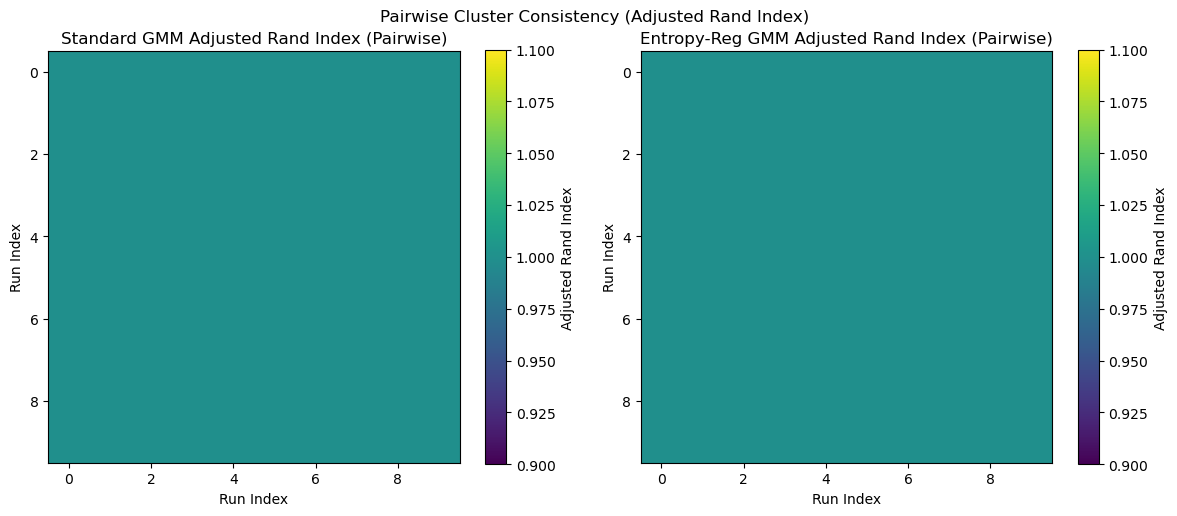

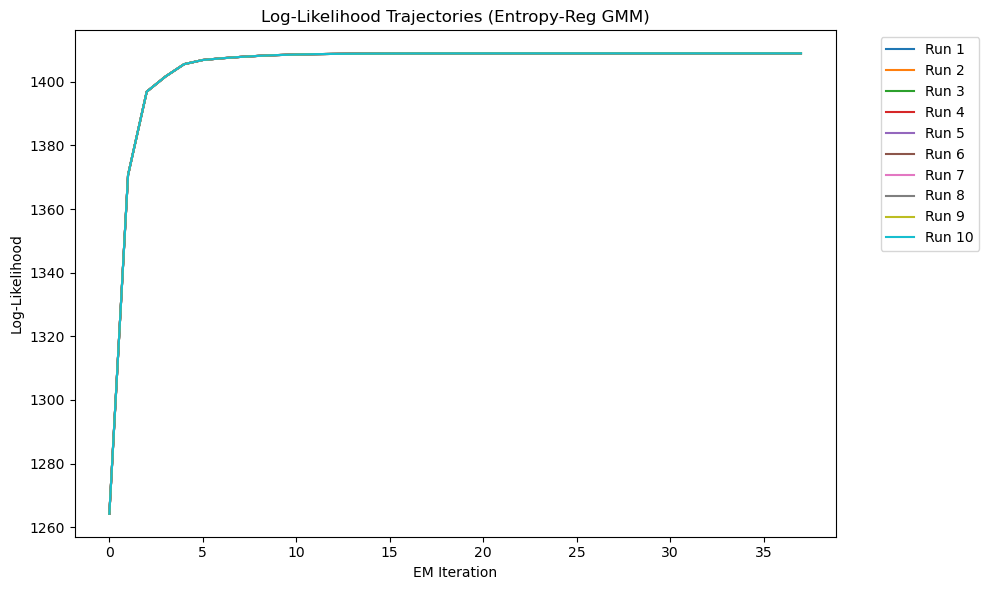

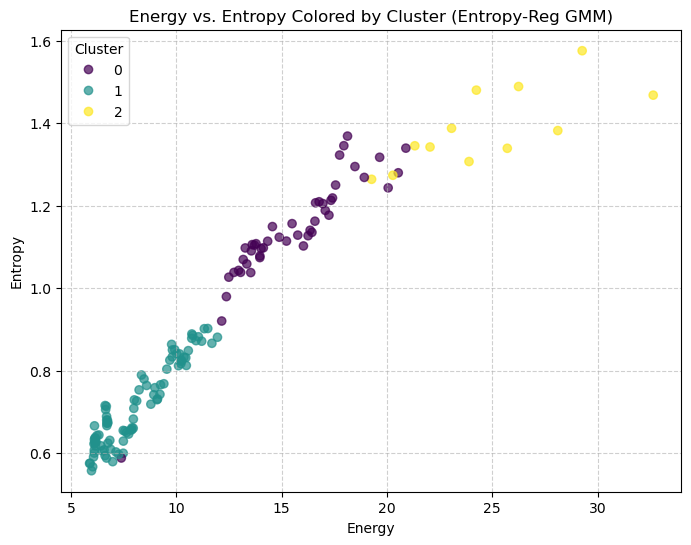


--- Summary of Extended Experimental Analysis ---
Standard GMM:
  Mean Final Log-Likelihood: 1411.93
  Mean Silhouette Score: 0.61
  Mean Pairwise ARI: 1.00

Entropy-Regularized GMM:
  Mean Final Log-Likelihood: 1408.95
  Mean Silhouette Score: 0.60
  Mean Pairwise ARI: 1.00

--- Model Evaluation and Comparison (Single Run) ---

Evaluating Standard GMM...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Evaluating Entropy-Regularized GMM...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Entropy-Regularized EM converged at iteration 27

--- Evaluation Results ---
Standard GMM:
  Final Log-Likelihood: 1411.9328
  BIC: -2513.2062
  AIC: -2699.8656
  Silhouette Score: 0.6079
  Computational Time (s): 1.5861

Entropy-Regularized GMM:
  Final Log-Likelihood: 1412.0083
  BIC (approx): -2513.3573
  AIC (approx): -2700.0167
  Silhouette Score: 0.6032
  Computational Time (s): 1.7672


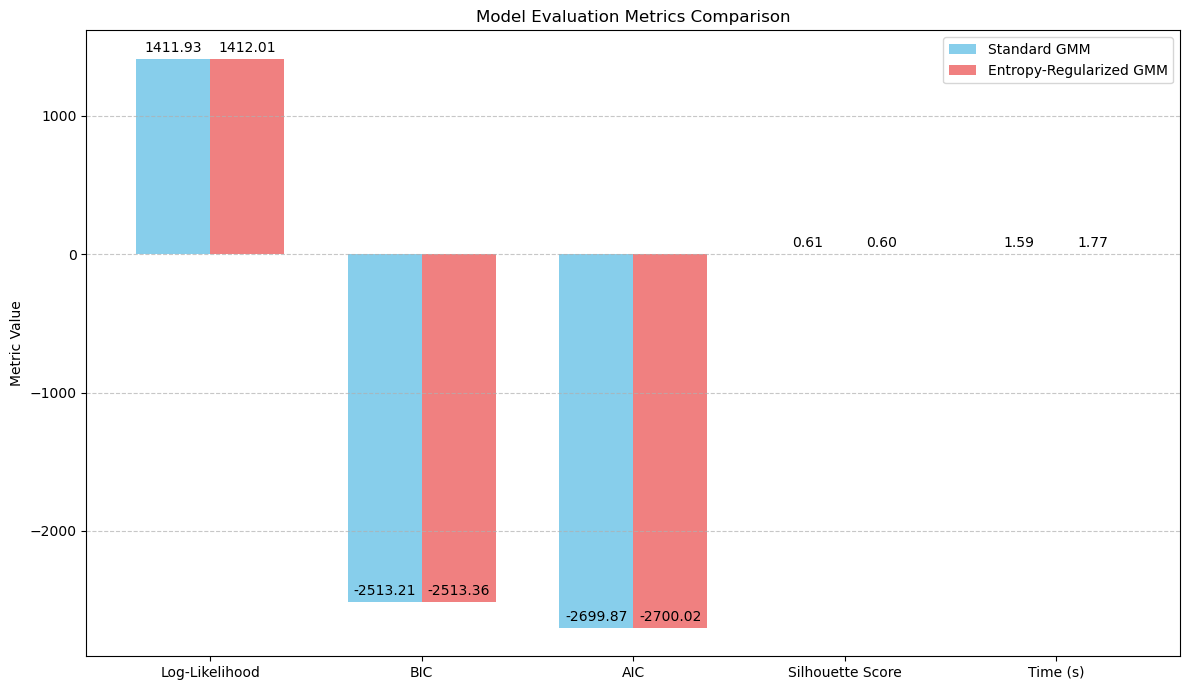


MSE across all evaluation metrics (unnormalized): 0.0168
Min–Max Normalization MSE: 0.0000
Z-Score Normalization MSE: 0.0000


In [34]:
from sklearn.metrics import adjusted_rand_score
# --- Sensitivity Analysis: Compute Pairwise ARI across runs ---
for i in range(num_runs_ext):
    for j in range(num_runs_ext):
        std_ari_matrix[i, j] = adjusted_rand_score(std_cluster_labels_ext[i], std_cluster_labels_ext[j])
        reg_ari_matrix[i, j] = adjusted_rand_score(reg_cluster_labels_ext[i], reg_cluster_labels_ext[j])

# Plot the ARI matrices as heatmaps
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.imshow(std_ari_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Adjusted Rand Index')
plt.title("Standard GMM Adjusted Rand Index (Pairwise)")
plt.xlabel("Run Index")
plt.ylabel("Run Index")

plt.subplot(1,2,2)
plt.imshow(reg_ari_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Adjusted Rand Index')
plt.title("Entropy-Reg GMM Adjusted Rand Index (Pairwise)")
plt.xlabel("Run Index")
plt.ylabel("Run Index")
plt.suptitle("Pairwise Cluster Consistency (Adjusted Rand Index)")
plt.tight_layout()
plt.savefig("GMM_ARI_Comparison.png")
plt.show()

# --- Log-Likelihood Trajectory Comparison ---
# Plot log-likelihood trajectories for entropy-regularized GMM for each run
plt.figure(figsize=(10, 6))
for idx, traj in enumerate(reg_loglikelihood_trajs_ext):
    plt.plot(traj, label=f'Run {idx+1}')
plt.xlabel("EM Iteration")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood Trajectories (Entropy-Reg GMM)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("EntropyReg_EM_Trajectories.png")
plt.show()

# --- Relationship between Clusters and Thermodynamic Variables ---
# For demonstration, assume that the first two columns of features represent Energy and Entropy.
energy = features[:, 0]
entropy = features[:, 1]

# Use the cluster labels from the entropy-regularized GMM from one run (e.g. first run)
selected_labels = reg_cluster_labels_ext[0] # Using labels from the first run of extended analysis

plt.figure(figsize=(8, 6))
scatter = plt.scatter(energy, entropy, c=selected_labels, cmap='viridis', alpha=0.7)
plt.xlabel("Energy")
plt.ylabel("Entropy")
plt.title("Energy vs. Entropy Colored by Cluster (Entropy-Reg GMM)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("Energy_Entropy_Clusters.png")
plt.show()

# Summary of Results for Extended Analysis:
print("\n--- Summary of Extended Experimental Analysis ---")
print("Standard GMM:")
print("  Mean Final Log-Likelihood: {:.2f}".format(np.mean(std_loglikelihoods_all_ext)))
print("  Mean Silhouette Score: {:.2f}".format(np.nanmean(std_silhouette_scores_ext))) # Use nanmean to handle NaNs
print("  Mean Pairwise ARI: {:.2f}".format(np.mean(std_ari_matrix[np.triu_indices(num_runs_ext, k=1)]))) # Average upper triangle
print("\nEntropy-Regularized GMM:")
print("  Mean Final Log-Likelihood: {:.2f}".format(np.mean(reg_loglikelihoods_all_ext)))
print("  Mean Silhouette Score: {:.2f}".format(np.nanmean(reg_silhouette_scores_ext))) # Use nanmean to handle NaNs
print("  Mean Pairwise ARI: {:.2f}".format(np.mean(reg_ari_matrix[np.triu_indices(num_runs_ext, k=1)]))) # Average upper triangle


# =============================================================================
# --- Model Evaluation and Comparison (Single Run) ---
# =============================================================================
print("\n--- Model Evaluation and Comparison (Single Run) ---")

# Set parameters for GMMs for this specific evaluation section
# These can be different from the parameters used in the sensitivity analysis if desired
num_components_eval = 3 
lambda_reg_eval = 0.1   

# Get the number of samples and features from the 'features' data
# 'features' is already defined from the averaged simulation data earlier in the script
n_samples, n_features = features.shape

# -------------------------------
# Standard GMM Evaluation (scikit-learn)
# -------------------------------
print("\nEvaluating Standard GMM...")
start_std = time.time()
gmm_std = GaussianMixture(n_components=num_components_eval, covariance_type='full', random_state=42, n_init=10)
gmm_std.fit(features)
std_time = time.time() - start_std

std_log_likelihood = gmm_std.score(features) * n_samples  # total log-likelihood
std_bic = gmm_std.bic(features)
std_aic = gmm_std.aic(features)
std_labels = gmm_std.predict(features)
# Calculate silhouette score only if there is more than one unique cluster
std_silhouette = silhouette_score(features, std_labels) if len(np.unique(std_labels)) > 1 else np.nan

# -------------------------------
# Entropy-Regularized GMM Evaluation
# -------------------------------
print("Evaluating Entropy-Regularized GMM...")
start_reg = time.time()
# Use the existing entropy_regularized_EM function
em_result_eval = entropy_regularized_EM(features, num_components_eval, lambda_reg=lambda_reg_eval, max_iter=200)
reg_time = time.time() - start_reg

reg_log_likelihood = em_result_eval["log_likelihoods"][-1]

# For our custom method, we compute approximate BIC and AIC.
# Number of free parameters p for a GMM is approximated as:
# p = (K - 1) + K*d + K*d*(d+1)/2, where K = num_components, d = n_features.
# K-1 for mixing coefficients, K*d for means, K*d*(d+1)/2 for full covariance matrices.
p_params = (num_components_eval - 1) + num_components_eval * n_features + num_components_eval * n_features * (n_features + 1) / 2
reg_bic = -2 * reg_log_likelihood + p_params * np.log(n_samples)
reg_aic = -2 * reg_log_likelihood + 2 * p_params

reg_labels = np.argmax(em_result_eval["responsibilities"], axis=1)
# Calculate silhouette score only if there is more than one unique cluster
reg_silhouette = silhouette_score(features, reg_labels) if len(np.unique(reg_labels)) > 1 else np.nan

# -------------------------------
# Print Evaluation Metrics
# -------------------------------
print("\n--- Evaluation Results ---")
print("Standard GMM:")
print(f"  Final Log-Likelihood: {std_log_likelihood:.4f}")
print(f"  BIC: {std_bic:.4f}")
print(f"  AIC: {std_aic:.4f}")
print(f"  Silhouette Score: {std_silhouette:.4f}")
print(f"  Computational Time (s): {std_time:.4f}")
print()
print("Entropy-Regularized GMM:")
print(f"  Final Log-Likelihood: {reg_log_likelihood:.4f}")
print(f"  BIC (approx): {reg_bic:.4f}")
print(f"  AIC (approx): {reg_aic:.4f}")
print(f"  Silhouette Score: {reg_silhouette:.4f}")
print(f"  Computational Time (s): {reg_time:.4f}")

# -------------------------------
# Plotting Comparison Metrics
# -------------------------------
metrics_names = ["Log-Likelihood", "BIC", "AIC", "Silhouette Score", "Time (s)"]
std_metrics = [std_log_likelihood, std_bic, std_aic, std_silhouette, std_time]
reg_metrics = [reg_log_likelihood, reg_bic, reg_aic, reg_silhouette, reg_time]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, std_metrics, width, label='Standard GMM', color='skyblue')
rects2 = ax.bar(x + width/2, reg_metrics, width, label='Entropy-Regularized GMM', color='lightcoral')

ax.set_ylabel('Metric Value')
ax.set_title('Model Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        # Handle NaN values for silhouette score gracefully
        text_val = f'{height:.2f}' if not np.isnan(height) else 'NaN'
        ax.annotate(text_val,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig("GMM_Model_Evaluation_Comparison.png")
plt.show()

# -------------------------------
# Compute MSE Across All Metrics
# -------------------------------
# Convert lists to numpy arrays for element-wise operations
std_metrics_array = np.array(std_metrics)
reg_metrics_array = np.array(reg_metrics)

# Handle NaN values before computing MSE. Replace NaN with a common value (e.g., 0 or the mean)
# For silhouette score, if one is NaN and the other is not, MSE will be affected.
# A robust way is to only compare non-NaN pairs or impute. For simplicity, we'll replace NaN with 0.
# This might not be ideal for all metrics but ensures MSE calculation.
std_metrics_array[np.isnan(std_metrics_array)] = 0
reg_metrics_array[np.isnan(reg_metrics_array)] = 0

mse_all = mean_squared_error(std_metrics_array, reg_metrics_array)
print(f"\nMSE across all evaluation metrics (unnormalized): {mse_all:.4f}")

# -------------------------------
# Normalization and MSE Calculation
# -------------------------------

def min_max_normalize(arr):
    """Applies Min-Max normalization to a numpy array."""
    min_val = np.min(arr)
    max_val = np.max(arr)
    if max_val == min_val: # Avoid division by zero if all values are the same
        return np.zeros_like(arr)
    return (arr - min_val) / (max_val - min_val)

def z_score_normalize(arr):
    """Applies Z-score normalization (standardization) to a numpy array."""
    mean_val = np.mean(arr)
    std_val = np.std(arr)
    if std_val == 0: # Avoid division by zero if standard deviation is zero
        return np.zeros_like(arr)
    return (arr - mean_val) / std_val

# Apply Min-Max Normalization
std_metrics_minmax = min_max_normalize(std_metrics_array)
reg_metrics_minmax = min_max_normalize(reg_metrics_array)
mse_minmax = mean_squared_error(std_metrics_minmax, reg_metrics_minmax)

# Apply Z-Score Normalization
std_metrics_z = z_score_normalize(std_metrics_array)
reg_metrics_z = z_score_normalize(reg_metrics_array)
mse_z = mean_squared_error(std_metrics_z, reg_metrics_z)

print(f"Min–Max Normalization MSE: {mse_minmax:.4f}")
print(f"Z-Score Normalization MSE: {mse_z:.4f}")


--- Time-Resolved KL Divergence Analysis of Energy Distributions ---
Window 0:20, data: [32.63603295 29.26289328 28.10582492 26.24404548 25.70862073 24.24018724
 23.8914369  23.06219994 22.04134625 21.31908044 20.89300904 20.53295465
 20.27564154 20.05353788 19.6484212  19.26698889 18.91980708 18.47594438
 18.12365522 17.94932482]
Window 5:25, data: [24.24018724 23.8914369  23.06219994 22.04134625 21.31908044 20.89300904
 20.53295465 20.27564154 20.05353788 19.6484212  19.26698889 18.91980708
 18.47594438 18.12365522 17.94932482 17.74856456 17.55771515 17.41132535
 17.33856907 17.24233004]
Window 10:30, data: [20.89300904 20.53295465 20.27564154 20.05353788 19.6484212  19.26698889
 18.91980708 18.47594438 18.12365522 17.94932482 17.74856456 17.55771515
 17.41132535 17.33856907 17.24233004 17.0668827  16.95459647 16.77463726
 16.60637913 16.57744244]
Window 15:35, data: [19.26698889 18.91980708 18.47594438 18.12365522 17.94932482 17.74856456
 17.55771515 17.41132535 17.33856907 17.2423

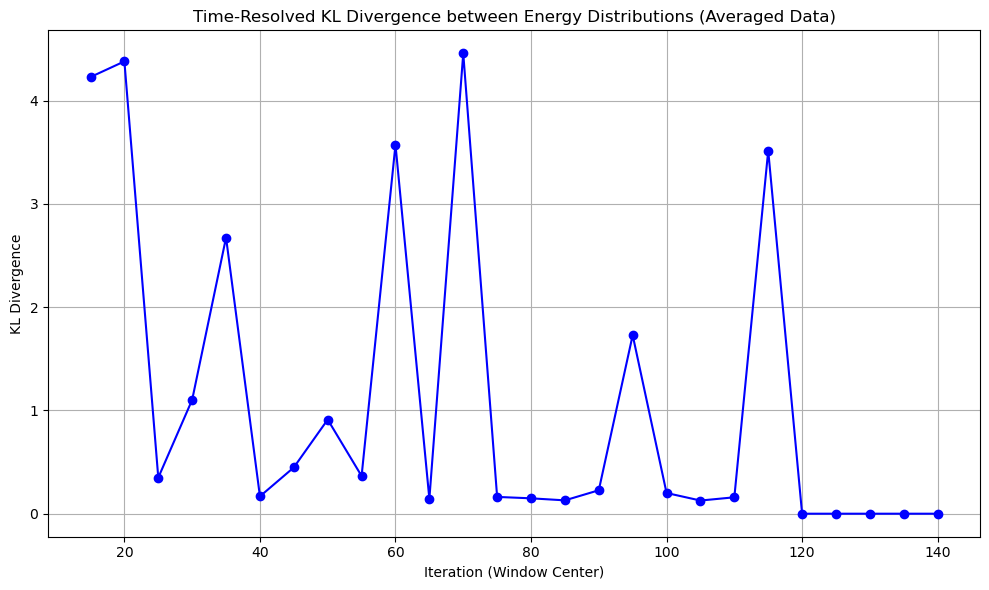

In [39]:
from scipy.stats import entropy
# =============================================================================
# --- Time-Resolved KL Divergence Analysis of Energy Distributions ---
# =============================================================================
print("\n--- Time-Resolved KL Divergence Analysis of Energy Distributions ---")

# Assume average_energy is a numpy array of energy values over simulation iterations.
# This variable is computed earlier in the main block from multiple simulation runs.
n_iter = len(average_energy)  # Should be 150 based on step_num

# Parameters for sliding window analysis
window_size = 20  # number of iterations per window
stride = 5        # step size for the sliding window

kl_divergences = []
window_centers = []

# Define common histogram bins across all windows.
# The 'ensemble' values (which average_energy is based on) range from 0 to 1.
# Using a fixed range ensures consistency across windows.
bins = np.linspace(np.min(average_energy), np.max(average_energy), 15)

prev_hist = None
# Iterate through the averaged energy data using a sliding window
for start in range(0, n_iter - window_size + 1, stride):
    end = start + window_size
    window_data = average_energy[start:end]
    print(f"Window {start}:{end}, data:", window_data)

    # Compute normalized histogram (PDF) for the current window
    # density=True normalizes the histogram so that the integral over the range is 1.
    hist, _ = np.histogram(window_data, bins=bins, density=True)
    hist += 1e-9  # Add a small epsilon to avoid log(0) in KL divergence calculation
    hist /= np.sum(hist) # Re-normalize to ensure sum is exactly 1 after adding epsilon

    if prev_hist is None:
        prev_hist = hist
    else:
        # Compute KL divergence D_KL(prev || current)
        # This measures how much the 'current' distribution diverges from the 'previous' one.
        kl = entropy(prev_hist, hist)
        kl_divergences.append(kl)
        # Calculate the center of the current window for plotting
        window_centers.append(start + window_size / 2)
        prev_hist = hist # Update previous histogram for the next iteration

# Plot KL divergence over simulation iterations
plt.figure(figsize=(10, 6))
plt.plot(window_centers, kl_divergences, marker='o', linestyle='-', color='blue')
plt.xlabel("Iteration (Window Center)")
plt.ylabel("KL Divergence")
plt.title("Time-Resolved KL Divergence between Energy Distributions (Averaged Data)")
plt.grid(True)
plt.tight_layout()
plt.savefig("KL_Divergence_Energy.png")
plt.show()



--- Time-Resolved KL Divergence Analysis of Energy Distributions (Smoothed) ---


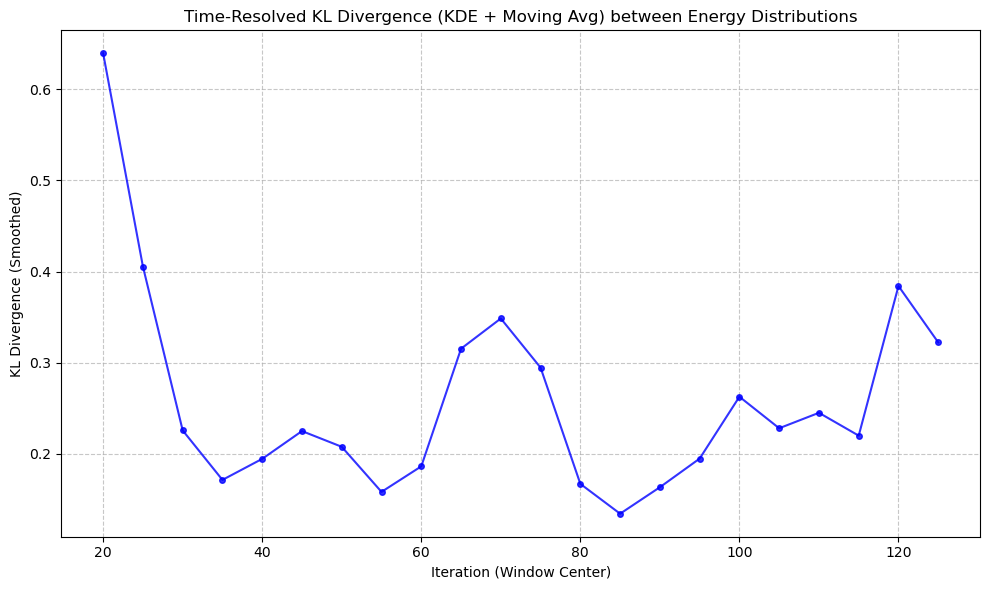

In [41]:
from scipy.stats import gaussian_kde
from sklearn.metrics import adjusted_rand_score

# =============================================================================
# --- Time-Resolved KL Divergence Analysis of Energy Distributions (Smoothed) ---
# =============================================================================
print("\n--- Time-Resolved KL Divergence Analysis of Energy Distributions (Smoothed) ---")

# `average_energy` is a numpy array of energy values over simulation iterations,
# computed earlier in the main block from multiple simulation runs.
n_iter = len(average_energy)

# Parameters for sliding window analysis
window_size = 30  # Larger window size for smoother KDE
stride = 5        # Step size for the sliding window

kl_divergences = []
window_centers = []

# Define KDE grid based on the full range of `average_energy` data.
# This ensures consistency across all windows and avoids issues with empty bins.
grid_min = np.min(average_energy) - 0.05 # Extend slightly beyond min/max for boundary effects
grid_max = np.max(average_energy) + 0.05
grid_x = np.linspace(grid_min, grid_max, 200) # Finer grid for smoother PDF estimation
dx = grid_x[1] - grid_x[0] # Step size for numerical integration

prev_pdf = None

# Slide window and compute KDE and KL divergence
for start in range(0, n_iter - window_size + 1, stride):
    end = start + window_size
    window_data = average_energy[start:end]
    
    # Check if window_data has enough points for KDE.
    # gaussian_kde requires at least 2 points for 1D data.
    if len(window_data) < 2:
        # If not enough data, skip this window or handle appropriately
        # For now, we'll just continue to the next window.
        print(f"Skipping window [{start}:{end}] due to insufficient data for KDE ({len(window_data)} points).")
        continue

    # Compute Kernel Density Estimate (KDE) for the current window's data
    kde = gaussian_kde(window_data)
    pdf = kde(grid_x) # Evaluate KDE on the defined grid
    
    # Add a small epsilon to PDF values to prevent log(0) in KL divergence
    pdf += 1e-9
    # Normalize the PDF so that its integral over the grid is 1
    # This is crucial for valid probability distributions in KL divergence.
    pdf /= np.sum(pdf * dx) 

    if prev_pdf is None:
        prev_pdf = pdf
    else:
        # Compute KL divergence D_KL(prev || current) manually for KDE outputs
        # D_KL(P || Q) = sum(P(x) * log(P(x) / Q(x))) * dx
        # Ensure no division by zero or log(0) by adding epsilon earlier.
        kl = np.sum(prev_pdf * np.log(prev_pdf / pdf)) * dx
        kl_divergences.append(kl)
        window_centers.append(start + window_size / 2)
        prev_pdf = pdf # Update previous PDF for the next iteration

kl_divergences = np.array(kl_divergences)
window_centers = np.array(window_centers)

# Moving average smoothing to further reduce noise in KL divergence values
def moving_average(data, window):
    """Applies a simple moving average filter to the data."""
    if len(data) < window:
        return np.array([np.mean(data)]) if len(data) > 0 else np.array([])
    return np.convolve(data, np.ones(window)/window, mode='valid')

smoothing_window = 3 # Window size for moving average
kl_smoothed = moving_average(kl_divergences, window=smoothing_window)

# Adjust window_centers to match the length of the smoothed KL divergences
# The valid mode of np.convolve reduces the output array length by (window - 1)
plot_window_centers = window_centers[:len(kl_smoothed)]

# Plot the smoothed KL divergence over simulation iterations
plt.figure(figsize=(10, 6))
plt.plot(plot_window_centers, kl_smoothed, marker='o', linestyle='-', color='blue', alpha=0.8, markersize=4)
plt.xlabel("Iteration (Window Center)")
plt.ylabel("KL Divergence (Smoothed)")
plt.title("Time-Resolved KL Divergence (KDE + Moving Avg) between Energy Distributions")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("KL_Divergence_KDE_Smoothed.png")
plt.show()

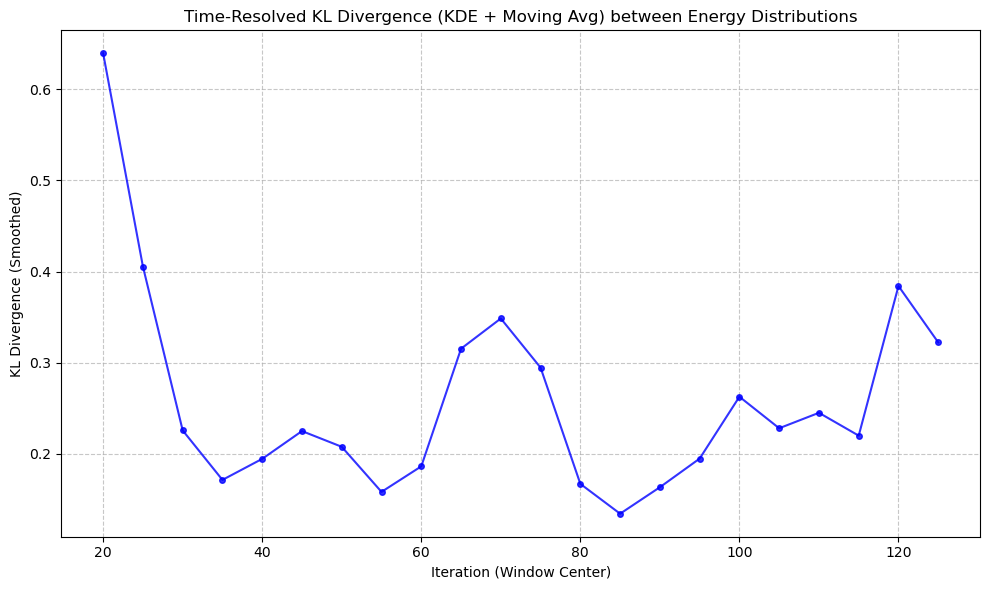

In [43]:
# Assume average_energy is a numpy array of energy values over simulation iterations.
# This variable would typically be computed from multiple simulation runs, as in the full Canvas code.
# For demonstration purposes, if running this snippet independently, you would need to define average_energy, e.g.:
# average_energy = np.random.rand(150) # Example dummy data

n_iter = len(average_energy)

# Parameters for sliding window analysis
window_size = 30  # Larger window size for smoother KDE
stride = 5        # Step size for the sliding window

kl_divergences = []
window_centers = []

# Define KDE grid based on the full range of `average_energy` data.
# This ensures consistency across all windows and avoids issues with empty bins.
grid_min = np.min(average_energy) - 0.05 # Extend slightly beyond min/max for boundary effects
grid_max = np.max(average_energy) + 0.05
grid_x = np.linspace(grid_min, grid_max, 200) # Finer grid for smoother PDF estimation
dx = grid_x[1] - grid_x[0] # Step size for numerical integration

prev_pdf = None

# Slide window and compute KDE and KL divergence
for start in range(0, n_iter - window_size + 1, stride):
    end = start + window_size
    window_data = average_energy[start:end]
    
    # Check if window_data has enough points for KDE.
    # gaussian_kde requires at least 2 points for 1D data.
    if len(window_data) < 2:
        # If not enough data, skip this window or handle appropriately
        # For now, we'll just continue to the next window.
        print(f"Skipping window [{start}:{end}] due to insufficient data for KDE ({len(window_data)} points).")
        continue

    # Compute Kernel Density Estimate (KDE) for the current window's data
    kde = gaussian_kde(window_data)
    pdf = kde(grid_x) # Evaluate KDE on the defined grid
    
    # Add a small epsilon to PDF values to prevent log(0) in KL divergence
    pdf += 1e-9
    # Normalize the PDF so that its integral over the grid is 1
    # This is crucial for valid probability distributions in KL divergence.
    pdf /= np.sum(pdf * dx) 

    if prev_pdf is None:
        prev_pdf = pdf
    else:
        # Compute KL divergence D_KL(prev || current) manually for KDE outputs
        # D_KL(P || Q) = sum(P(x) * log(P(x) / Q(x))) * dx
        # Ensure no division by zero or log(0) by adding epsilon earlier.
        kl = np.sum(prev_pdf * np.log(prev_pdf / pdf)) * dx
        kl_divergences.append(kl)
        window_centers.append(start + window_size / 2)
        prev_pdf = pdf # Update previous PDF for the next iteration

kl_divergences = np.array(kl_divergences)
window_centers = np.array(window_centers)

# Moving average smoothing to further reduce noise in KL divergence values
def moving_average(data, window):
    """Applies a simple moving average filter to the data."""
    if len(data) < window:
        return np.array([np.mean(data)]) if len(data) > 0 else np.array([])
    return np.convolve(data, np.ones(window)/window, mode='valid')

smoothing_window = 3 # Window size for moving average
kl_smoothed = moving_average(kl_divergences, window=smoothing_window)

# Adjust window_centers to match the length of the smoothed KL divergences
# The valid mode of np.convolve reduces the output array length by (window - 1)
plot_window_centers = window_centers[:len(kl_smoothed)]

# Plot the smoothed KL divergence over simulation iterations
plt.figure(figsize=(10, 6))
plt.plot(plot_window_centers, kl_smoothed, marker='o', linestyle='-', color='blue', alpha=0.8, markersize=4)
plt.xlabel("Iteration (Window Center)")
plt.ylabel("KL Divergence (Smoothed)")
plt.title("Time-Resolved KL Divergence (KDE + Moving Avg) between Energy Distributions")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("KL_Divergence_KDE_Smoothed.png")
plt.show()

Running Entropy-Regularized EM to get effective counts (N_k) for λ=0.1...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Derived effective counts (N_k) from data: [47.08860054 90.72022275 10.19117639]


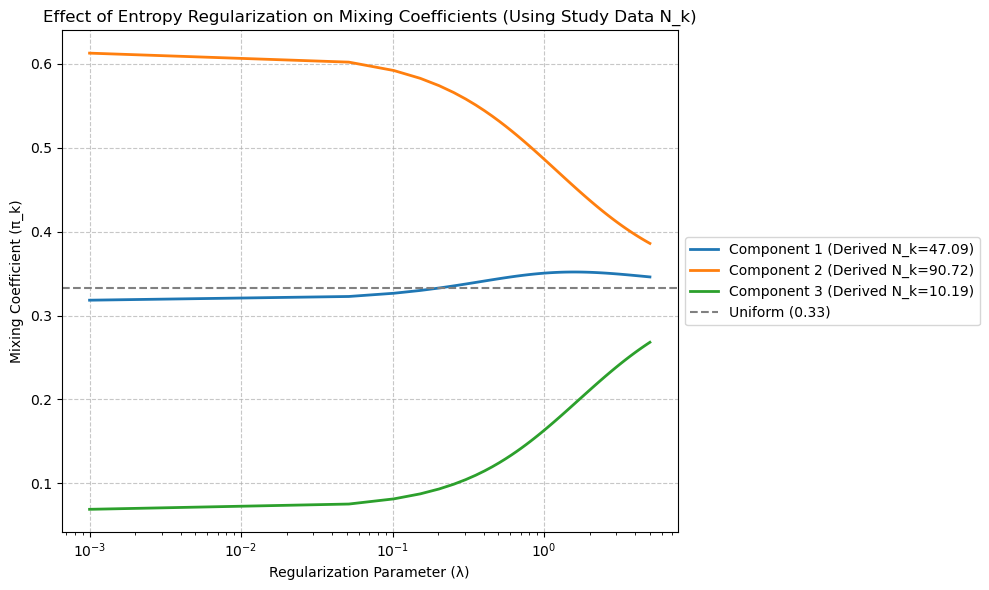


Plot 'entropy_softmax_curve.png' generated successfully using effective counts derived from study data.

Interpretation:
This plot shows how the mixing coefficients (π_k) for the 3 clusters, derived from your averaged thermodynamic features, are influenced by the entropy regularization parameter (λ).
As λ increases, the π_k values are 'pulled' towards a more uniform distribution (here, 0.33 for each component). This illustrates the regularization's role in encouraging a softer, less 'winner-take-all' assignment of data points to clusters, potentially leading to more robust GMM training results.


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans # Required for entropy_regularized_EM initialization

# --- Re-defining entropy_regularized_EM function for standalone execution ---
# This function is crucial for calculating the responsibilities (and thus N_k)
# from the 'features' data. It needs to be defined here if this snippet is run separately.
# If this code is integrated into the main script, this re-definition is redundant
# and the existing function from the main script should be used.

def entropy_regularized_EM(X, num_components, lambda_reg=0.5, max_iter=200, tol=1e-5):
    """
    Implements an entropy-regularized Expectation-Maximization (EM) algorithm for GMM.
    This variant modifies the M-step for mixing coefficients by adding an entropy term,
    which can lead to more robust clustering less sensitive to initialization.
    
    Args:
        X (np.array): Input data array of shape (n_samples, n_features).
        num_components (int): Number of Gaussian components (K).
        lambda_reg (float): Regularization parameter (λ) controlling the entropy term.
                            When lambda_reg=0, the update reduces to standard EM.
        max_iter (int): Maximum number of iterations for the EM algorithm.
        tol (float): Tolerance for convergence (change in log-likelihood).
    
    Returns:
        dict: A dictionary containing the learned parameters and convergence history:
            'pi': mixing coefficients (1D array)
            'mu': means (array of shape (K, n_features))
            'cov': covariances (array of shape (K, n_features, n_features))
            'log_likelihoods': list of log-likelihood values over iterations
            'responsibilities': final responsibility matrix (n_samples x K)
    """
    n_samples, n_features = X.shape
    
    # Initialize means using MiniBatchKMeans for better stability
    kmeans = MiniBatchKMeans(n_clusters=num_components, random_state=42, n_init=10)
    kmeans.fit(X)
    mu = kmeans.cluster_centers_

    # Initialize covariances as scaled identity matrices or sample covariance
    cov = np.array([np.cov(X.T) + 1e-6*np.eye(n_features) for _ in range(num_components)])
    
    # Initialize mixing coefficients uniformly
    pi = np.ones(num_components) / num_components
    
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # ----- E-step: Compute responsibilities (gamma_nk) -----
        resp = np.zeros((n_samples, num_components))
        for k in range(num_components):
            try:
                # Calculate multivariate normal probability density for each data point
                diff = X - mu[k]
                inv_cov = np.linalg.inv(cov[k])
                det_cov = np.linalg.det(cov[k])
                
                # Handle potential numerical issues with determinant
                if det_cov <= 0:
                    det_cov = 1e-9 # Small positive value to avoid errors
                
                norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov)
                exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
                resp[:, k] = pi[k] * norm_const * np.exp(exponent)
            except np.linalg.LinAlgError:
                # Fallback in case of singular covariance matrix
                # print(f"Singular covariance matrix encountered for component {k} in E-step. Adding jitter and retrying.")
                cov[k] += 1e-6 * np.eye(n_features) 
                # Recalculate after adding jitter
                diff = X - mu[k]
                inv_cov = np.linalg.inv(cov[k])
                det_cov = np.linalg.det(cov[k])
                if det_cov <= 0: det_cov = 1e-9
                norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov)
                exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
                resp[:, k] = pi[k] * norm_const * np.exp(exponent)


        resp_sum = np.sum(resp, axis=1, keepdims=True)
        # Normalize responsibilities; add epsilon to avoid division by zero
        resp = resp / (resp_sum + 1e-9) 
        
        # ----- M-step: Update parameters (pi, mu, cov) -----
        N_k = np.sum(resp, axis=0)  # Effective number of points assigned to each component
        
        # Update means (mu_k)
        mu_new = np.zeros_like(mu)
        for k in range(num_components):
            if N_k[k] > 1e-9: # Only update if effective count is non-zero
                mu_new[k] = np.sum(resp[:, k][:, np.newaxis] * X, axis=0) / N_k[k]
        mu = mu_new
        
        # Update covariances (cov_k)
        cov_new = np.zeros_like(cov)
        for k in range(num_components):
            if N_k[k] > 1e-9:
                diff = X - mu[k]
                cov_new[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
                cov_new[k] += 1e-6 * np.eye(n_features)  # Add regularization for stability
        cov = cov_new
        
        # Update mixing coefficients (pi_k) with entropy regularization:
        # pi_k = (N_k)^(1/(1+λ)) / Σ_j (N_j)^(1/(1+λ))
        exponent_val = 1.0 / (1.0 + lambda_reg)
        pi_new = N_k ** exponent_val
        pi_new = pi_new / np.sum(pi_new) # Normalize to sum to 1
        pi = pi_new
        
        # Compute the log-likelihood of the data given the current parameters
        current_log_likelihood = 0.0
        for i in range(n_samples):
            temp_sum = 0.0
            for k in range(num_components):
                try:
                    # Re-calculate PDF for log-likelihood summation
                    diff_i = X[i] - mu[k]
                    inv_cov_k = np.linalg.inv(cov[k])
                    det_cov_k = np.linalg.det(cov[k])
                    
                    if det_cov_k <= 0: 
                        det_cov_k = 1e-9
                    
                    norm_const_i = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_cov_k)
                    temp_sum += pi[k] * norm_const_i * np.exp(-0.5 * diff_i.T @ inv_cov_k @ diff_i)
                except np.linalg.LinAlgError:
                    temp_sum += 1e-9 # Add small value if covariance becomes singular
            current_log_likelihood += np.log(temp_sum + 1e-9) # Add epsilon to avoid log(0)
        log_likelihoods.append(current_log_likelihood)
        
        # Check for convergence based on change in log-likelihood
        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            # print(f"Entropy-Regularized EM converged at iteration {iteration}")
            break
    
    return {
        "pi": pi,
        "mu": mu,
        "cov": cov,
        "log_likelihoods": log_likelihoods,
        "responsibilities": resp
    }


# --- Function to calculate regularized mixing coefficients ---
def calculate_regularized_mixing_coefficients(N_k, lambda_reg):
    """
    Calculates mixing coefficients (pi_k) with entropy regularization.
    Based on the M-step update: pi_k = (N_k)^(1/(1+λ)) / Σ_j (N_j)^(1/(1+λ)).

    Args:
        N_k (np.array): Effective counts for each component (sum of responsibilities).
        lambda_reg (float): The entropy regularization parameter (λ).

    Returns:
        np.array: The normalized mixing coefficients (pi_k).
    """
    N_k = np.asarray(N_k, dtype=np.float64)
    N_k_stable = N_k + 1e-9 # Add epsilon for numerical stability

    exponent = 1.0 / (1.0 + lambda_reg)
    numerator = N_k_stable ** exponent
    denominator = np.sum(numerator)
    pi_k = numerator / denominator
    return pi_k

# --- Data from the Study (assuming these are available from the main script execution) ---
# For this standalone snippet to run, you would need to have 'features' defined.
# In the full study code, 'features' is derived from 'averaged_model_data_df'.
# For demonstration purposes if running this snippet alone, you might use dummy data:
# features = np.random.rand(150, 5) # Example: 150 samples, 5 features

# To use the actual data, ensure 'features' is passed or available in the scope.
# Assuming 'features' is available from the previous execution context:
# features = ... (this would be the `features` array from your main script)

# Example: If you run this code snippet independently, uncomment and use dummy data:
# np.random.seed(0)
# features = np.random.rand(150, 5) # Dummy feature data for standalone test

# --- Parameters for EM and Plotting ---
num_components = 3 # Number of components for the GMM
# We'll use a fixed lambda_reg to run EM once to get representative N_k
# This lambda_reg can be one of the values you're interested in, e.g., 0.1 or 0.5
fixed_lambda_for_nk = 0.1 

# 1. Run Entropy-Regularized EM on the features data to get responsibilities
print(f"Running Entropy-Regularized EM to get effective counts (N_k) for λ={fixed_lambda_for_nk}...")
em_result_for_nk = entropy_regularized_EM(features, num_components, lambda_reg=fixed_lambda_for_nk, max_iter=200)

# 2. Extract the effective counts (N_k) from the final responsibilities
effective_counts_from_data = np.sum(em_result_for_nk["responsibilities"], axis=0)
print(f"Derived effective counts (N_k) from data: {effective_counts_from_data}")

# 3. Define a range of lambda_reg values to explore for the curve
lambda_reg_values = np.linspace(0.001, 5.0, 100) # From very small to larger values

# 4. Store the calculated mixing coefficients for plotting across the lambda_reg range
pi_coefficients_per_lambda = []

# Calculate pi_k for each lambda_reg value using the derived effective_counts
for l_reg in lambda_reg_values:
    pi_k = calculate_regularized_mixing_coefficients(effective_counts_from_data, l_reg)
    pi_coefficients_per_lambda.append(pi_k)

# Convert list of arrays to a 2D numpy array for easier plotting
pi_coefficients_per_lambda = np.array(pi_coefficients_per_lambda)

# --- Plotting the Entropy Softmax Curve ---
plt.figure(figsize=(10, 6))

# Plot each component's mixing coefficient over lambda_reg values
for i in range(effective_counts_from_data.shape[0]):
    plt.plot(lambda_reg_values, pi_coefficients_per_lambda[:, i], 
             label=f'Component {i+1} (Derived N_k={effective_counts_from_data[i]:.2f})', linewidth=2)

# Add a horizontal line at 1/K to show the uniform distribution target
uniform_pi = 1.0 / num_components
plt.axhline(y=uniform_pi, color='gray', linestyle='--', label=f'Uniform ({uniform_pi:.2f})')

plt.xlabel("Regularization Parameter (λ)")
plt.ylabel("Mixing Coefficient (π_k)")
plt.title("Effect of Entropy Regularization on Mixing Coefficients (Using Study Data N_k)")
plt.xscale('log') # Use log scale for lambda_reg to better visualize small values
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("entropy_softmax_curve.png")
plt.show()

print("\nPlot 'entropy_softmax_curve.png' generated successfully using effective counts derived from study data.")
print("\nInterpretation:")
print(f"This plot shows how the mixing coefficients (π_k) for the {num_components} clusters, derived from your averaged thermodynamic features, are influenced by the entropy regularization parameter (λ).")
print(f"As λ increases, the π_k values are 'pulled' towards a more uniform distribution (here, {uniform_pi:.2f} for each component). This illustrates the regularization's role in encouraging a softer, less 'winner-take-all' assignment of data points to clusters, potentially leading to more robust GMM training results.")